# Start of the file
-   robust MAD normalization and clipping, k=10
-   model training, training / validation as 0.9/0.1 splitting 


In [ ]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from collections import Counter
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import hdbscan
import os
import torch
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.utils.data import DataLoader, Dataset
from sklearn.manifold import TSNE
import pickle
from sklearn.model_selection import train_test_split

print(torch.__version__)
print(torch.cuda.is_available())  # Check if CUDA is available (if using GPU)
print(torch.cuda.device_count())  # Check how many GPUs are available
print(torch.cuda.get_device_name(0))  # Get the name of the first GPU
print(torch.cuda.current_device())  # Get the current GPU device

# Check if cuDNN is enabled
print(torch.backends.cudnn.enabled)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))


2.6.0+cu118
True
1
NVIDIA GeForce RTX 4060 Ti
0
True
cuda:0
2026-01-28 14:54:49


# Preprocess

In [5]:
with open("files_dataframe.pickle", "rb") as f:
  files_dataframe = pickle.load(f)



In [6]:
from scipy.stats import median_abs_deviation
from tqdm import tqdm

def preprocess_lcs_per_object(df, set='train'):
    """
    Preprocess TESS light curves with per-object normalization and uncertainty weighting.
    
    Key changes from original:
    1. Per-object normalization (median + robust MAD scaling)
    2. Inverse-variance weighting using uncertainties
    3. Outlier handling using robust statistics per object
    4. Preserves astrophysical information while normalizing scale
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe with columns: 'object_name', 'tess_flux', 'tess_uncert', 'relative_time'
    set : str
        Dataset identifier ('train', 'val', 'test')
    
    Returns
    -------
    oids_used : list
        Object IDs that passed preprocessing
    target_class : list
        Class labels (if available) or object names
    data : list of np.array
        Normalized time-flux pairs for each object
    uncertainties : list of np.array
        Scaled uncertainties (time-uncertainty pairs)
    weights : list of np.array
        Inverse-variance weights for each data point
    normalization_params : dict
        Parameters used for normalization (for inverse transformation)
    """
    
    # Clean data
    df = df.copy()
    df = df[~df['tess_flux'].isna() & ~df['tess_uncert'].isna()]
    
    oids = np.unique(df['object_name'])
    
    data = []
    uncertainties = []
    weights = []
    target_class = []
    oids_used = []
    normalization_params = {}  # Store for potential inverse transformation
    
    print(f"=== Preprocessing with per-object normalization ===")
    print(f"Number of objects: {len(oids)}")
    
    for oid in tqdm(oids, desc=f"Processing {set} objects"):
        lc = df[df['object_name'] == oid].copy()
        
        if len(lc) < 20:  # Minimum points requirement
            continue
        
        # 1. Handle extreme outliers per object using robust statistics
        # Use median and MAD instead of mean/std for outlier detection
        median_flux = np.median(lc['tess_flux'])
        mad_flux = median_abs_deviation(lc['tess_flux'], scale='normal')
        
        # Define outlier bounds (e.g., median ± 5*MAD)
        lower_bound = median_flux - 10 * mad_flux
        upper_bound = median_flux + 10 * mad_flux
        
        # Clip extreme outliers (not all high/low values, just extremes)
        n_extreme = ((lc['tess_flux'] < lower_bound) | (lc['tess_flux'] > upper_bound)).sum()
        if n_extreme > 0:
            # Cap extreme values at bounds (preserves more data than removal)
            lc.loc[lc['tess_flux'] < lower_bound, 'tess_flux'] = lower_bound
            lc.loc[lc['tess_flux'] > upper_bound, 'tess_flux'] = upper_bound
        
        # 2. PER-OBJECT NORMALIZATION
        # Calculate robust normalization parameters
        robust_median = np.median(lc['tess_flux'])
        robust_mad = median_abs_deviation(lc['tess_flux'], scale='normal')
        
        # Handle edge case: very small or zero variability
        if robust_mad < 1e-10:
            # Use standard deviation as fallback
            robust_mad = np.std(lc['tess_flux'])
            if robust_mad < 1e-10:
                robust_mad = 1.0  # Avoid division by zero
        
        # Normalize flux: (flux - median) / robust_mad
        # This gives zero median, unit robust variance
        flux_normalized = (lc['tess_flux'] - robust_median) / robust_mad
        
        # Scale uncertainties by the same factor
        uncert_scaled = lc['tess_uncert'] / robust_mad
        
        # 3. INVERSE-VARIANCE WEIGHTING
        # Weight = 1/σ² (inverse variance)
        # Add small epsilon to avoid division by zero
        epsilon = 1e-10
        weights_raw = 1.0 / (uncert_scaled**2 + epsilon)
        
        # Normalize weights to have max weight = 1 (optional but helps training)
        if weights_raw.max() > 0:
            weights_normalized = weights_raw / weights_raw.max()
        else:
            weights_normalized = np.ones_like(weights_raw)
        
        # 4. Time normalization (relative to start)
        time_normalized = lc['relative_time'] - np.min(lc['relative_time'])
        
        # 5. Store normalization parameters for this object
        normalization_params[oid] = {
            'median': robust_median,
            'mad': robust_mad,
            'n_points': len(lc),
            'n_extreme_clipped': n_extreme
        }
        
        # 6. Subsampling to fixed length (if needed for your model)
        if len(lc) > 100:
            # IMPORTANT: Sample while preserving time order and uncertainties
            indices = np.linspace(0, len(lc)-1, 100, dtype=int)
            flux_normalized = flux_normalized.iloc[indices]
            time_normalized = time_normalized.iloc[indices]
            uncert_scaled = uncert_scaled.iloc[indices]
            weights_normalized = weights_normalized[indices]
        
        elif len(lc) < 30:  # Skip objects with too few points after potential subsampling
            continue
        
        # 7. Prepare output arrays
        # Data: [time, normalized_flux]
        data.append(np.column_stack([time_normalized.values, flux_normalized.values]))
        
        # Uncertainties: [time, scaled_uncertainty]
        uncertainties.append(np.column_stack([time_normalized.values, uncert_scaled.values]))
        
        # Weights: inverse-variance weights
        weights.append(weights_normalized)
        
        # Store object info
        oids_used.append(oid)
        target_class.append(oid)  # Or use actual class if available
        
        # Optional: Store class label if available in dataframe
        if 'class' in lc.columns:
            target_class[-1] = lc['class'].iloc[0]
    
    print(f"=== Preprocessing complete ===")
    print(f"Processed objects: {len(oids_used)} / {len(oids)}")
    print(f"Average points per object: {np.mean([len(d) for d in data]):.1f}")
    
    # Print summary statistics
    if normalization_params:
        medians = [p['median'] for p in normalization_params.values()]
        mads = [p['mad'] for p in normalization_params.values()]
        print(f"Median of medians: {np.median(medians):.2f}")
        print(f"Median MAD: {np.median(mads):.2f}")
        print(f"Total extreme values clipped: {sum([p['n_extreme_clipped'] for p in normalization_params.values()])}")
    
    return oids_used, target_class, data, uncertainties, weights, normalization_params


# Use the enhanced preprocessing
all_ids, all_labels, all_data, all_uncertainties, all_weights, normalization_params = preprocess_lcs_per_object(files_dataframe)

=== Preprocessing with per-object normalization ===
Number of objects: 3659


Processing train objects: 100%|██████████| 3659/3659 [00:19<00:00, 188.74it/s]

=== Preprocessing complete ===
Processed objects: 3593 / 3659
Average points per object: 46.2
Median of medians: 193.28
Median MAD: 983.81
Total extreme values clipped: 1072


In [7]:
class UncertaintyAwareLCDataset(Dataset):
    def __init__(self, data, uncertainties, weights, targets, ids, transform=None):
        self.data = data
        self.uncertainties = uncertainties
        self.weights = weights
        self.targets = targets
        self.ids = ids
        self.lengths = [len(seq) for seq in data]
        self.transform = transform

    def __getitem__(self, index):
        data = self.data[index]
        uncertainty = self.uncertainties[index]
        weights = self.weights[index]
        targets = self.targets[index]
        ids = self.ids[index]
        lengths = self.lengths[index]

        if self.transform:
            data = self.transform(data)
            uncertainty = self.transform(uncertainty)

        return data, uncertainty, weights, targets, ids, lengths

    def __len__(self):
        return len(self.data)

def uncertainty_collate_fn(batch):
    """Enhanced collate function that handles uncertainties and weights"""
    
    data, uncertainties, weights, targets, ids, lengths = zip(*batch)

    # Convert sequences to tensors and pad them
    sequences = [torch.tensor(d, dtype=torch.float32) for d in data]
    padded_sequences = pad_sequence(sequences, batch_first=True)
    
    # Pad uncertainties
    uncertainty_sequences = [torch.tensor(u, dtype=torch.float32) for u in uncertainties]
    padded_uncertainties = pad_sequence(uncertainty_sequences, batch_first=True)
    
    # Pad weights
    weight_sequences = [torch.tensor(w, dtype=torch.float32) for w in weights]
    padded_weights = pad_sequence(weight_sequences, batch_first=True)

    # Convert other data to tensors
    targets = torch.tensor(targets)
    ids = torch.tensor(ids)
    lengths = torch.tensor(lengths)

    return padded_sequences, padded_uncertainties, padded_weights, targets, ids, lengths

# Create enhanced datasets and data loaders
all_ds = UncertaintyAwareLCDataset(
    all_data, all_uncertainties, all_weights,
    [all_labels.index(id) for id in all_labels], 
    [all_ids.index(id) for id in all_ids]
)

all_loader = DataLoader(
    all_ds,
    batch_size=128,
    num_workers=0,
    shuffle=True,
    collate_fn=uncertainty_collate_fn,
    pin_memory=torch.cuda.is_available()
)

all_loader_no_shuffle = DataLoader(
    all_ds,
    batch_size=128,
    num_workers=0,
    shuffle=False,
    collate_fn=uncertainty_collate_fn,
    pin_memory=torch.cuda.is_available()
)

In [8]:
train_ids, val_ids, train_labels, val_labels, train_data, val_data, \
train_uncertainties, val_uncertainties, train_weights, val_weights = train_test_split(all_ids, all_labels, all_data, 
                                                    all_uncertainties, all_weights, test_size=0.1, random_state=42)

train_final_ids = [train_ids.index(id) for id in train_ids]
train_final_labels = [train_labels.index(id) for id in train_labels]

train_ds = UncertaintyAwareLCDataset(train_data, train_uncertainties, train_weights,
                                     [train_labels.index(id) for id in train_labels], [train_ids.index(id) for id in train_ids])
train_loader = DataLoader(
    train_ds,
    batch_size=128,
    num_workers=0,
    shuffle=True,
    collate_fn=uncertainty_collate_fn,
    pin_memory=torch.cuda.is_available()
)

val_ds = UncertaintyAwareLCDataset(val_data, val_uncertainties, val_weights,
                                   [val_labels.index(id) for id in val_labels], [val_ids.index(id) for id in val_ids] )
val_loader = DataLoader(
    val_ds,
    batch_size=128,
    num_workers=0,
    shuffle=True,
    collate_fn=uncertainty_collate_fn,
    pin_memory=torch.cuda.is_available()
)

# training

In [9]:
from src.util import Encoder, Decoder

class UncertaintyAwareRNN_VAE(torch.nn.Module):
    """RNN-VAE that incorporates measurement uncertainties"""
    
    def __init__(self, input_size=2, hidden_size=64, latent_size=16, dropout=0.2):
        super(UncertaintyAwareRNN_VAE, self).__init__()
        self.device = device
        
        # dimensions
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.num_layers = 4
        self.dropout = dropout
        
        self.enc = Encoder(input_size=input_size, hidden_size=hidden_size, 
                          num_layers=self.num_layers, dropout=self.dropout)
        
        self.dec = Decoder(
            input_size=latent_size,
            output_size=input_size,
            hidden_size=hidden_size,
            dropout=self.dropout,
            num_layers=self.num_layers,
        )
        
        self.fc21 = torch.nn.Linear(self.hidden_size, self.latent_size)
        self.fc22 = torch.nn.Linear(self.hidden_size, self.latent_size)
        self.fc3 = torch.nn.Linear(self.latent_size, self.hidden_size)
    
    def reparameterize(self, mu, logvar):
        if self.training:
            return mu + torch.randn(mu.shape).to(device)*torch.exp(0.5*logvar)
        else:
            return mu
    
    def forward(self, x, lengths, weights=None):
        batch_size, seq_len, feature_dim = x.shape
        
        # encode input space
        enc_output, enc_hidden = self.enc(x, lengths)
        
        # Correctly accessing the hidden state of the last layer
        enc_h = enc_hidden[-1].to(device)
        
        # extract latent variable z
        mu = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparameterize(mu, logvar)
        
        # initialize hidden state
        h_ = self.fc3(z)
        h_ = h_.unsqueeze(0)
        h_ = h_.repeat(self.dec.num_layers, 1, 1)
        
        # decode latent space
        z = z.repeat(1, seq_len, 1)
        z = z.view(batch_size, seq_len, self.latent_size).to(device)
        
        # initialize hidden state
        hidden = h_.contiguous()
        x_hat, hidden = self.dec(z, hidden)
        
        return x_hat, mu, logvar

def uncertainty_weighted_ELBO(x_hat, x, mu, logvar, weights=None):
    """ELBO loss with uncertainty weighting"""
    
    # Reconstruction loss with uncertainty weights
    if weights is not None:
        # Expand weights to match x shape if needed
        if weights.dim() == 2:  # [batch_size, seq_len]
            weights = weights.unsqueeze(-1)  # [batch_size, seq_len, 1]
        
        # Weighted MSE
        weighted_MSE = torch.sum(weights * (x_hat - x)**2)
    else:
        weighted_MSE = torch.nn.MSELoss(reduction='sum')(x_hat, x)
    
    # KL divergence (unchanged)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return weighted_MSE + KLD

In [ ]:
# def train_uncertainty_aware_vae(hidden_size=128, latent_size=16, nepochs=800):

from pathlib import Path
from src.util import save_checkpoint, plot_model_loss


hidden_size=128
latent_size=16
nepochs = 600
num_layers = 4

# save checkpoint every 20 epochs 
checkpoint_increment = 20

# Create a single folder
checkpoint_path = Path(f"checkpoint\RNN_VAE_lat{latent_size}_hid{hidden_size}_gru{num_layers}_norm_uncert_v20251213")
checkpoint_path.mkdir(parents=True, exist_ok=True)
print(f"checkpoint_path: {checkpoint_path}")

"""Training function that incorporates uncertainties"""

model = UncertaintyAwareRNN_VAE(hidden_size=hidden_size, latent_size=latent_size)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-4)

training_losses = []
validation_losses = []

print("Beginning uncertainty-aware training...")
for epoch in range(nepochs):
    # Training phase
    model.train()
    train_loss = 0
    
    for x, uncertainties, weights, labels, ids, lengths in train_loader:
        x = x.to(device)
        weights = weights.to(device)
        
        x_hat, mu, logvar = model(x, lengths)
        loss = uncertainty_weighted_ELBO(x_hat, x, mu, logvar, weights)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    training_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for x, uncertainties, weights, labels, ids, lengths in val_loader:
            x = x.to(device)
            weights = weights.to(device)
            
            x_hat, mu, logvar = model(x, lengths)
            loss = uncertainty_weighted_ELBO(x_hat, x, mu, logvar, weights)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    validation_losses.append(avg_val_loss)

    print(f'Epoch {epoch} | Train: {avg_train_loss:.2f} | Val: {avg_val_loss:.2f}')

        # Save model checkpoint every checkpoint_increment epochs
    if (epoch + 1) % checkpoint_increment == 0:
        checkpoint_path_file = f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epoch+1}.pth'
        save_checkpoint(epoch+1, model, optimizer, avg_train_loss, avg_val_loss, training_losses, validation_losses, path=checkpoint_path_file)
        print(f'Model checkpoint saved at {checkpoint_path_file}')

plot_model_loss(training_losses, validation_losses)


# load model

can skip

In [10]:

from pathlib import Path
from src.util import save_checkpoint, plot_model_loss


hidden_size=128
latent_size=16
nepochs = 600
num_layers = 4

# save checkpoint every 20 epochs 
checkpoint_increment = 20

# Create a single folder
checkpoint_path = Path(f"checkpoint\RNN_VAE_lat{latent_size}_hid{hidden_size}_gru{num_layers}_norm_uncert_v20251213")
checkpoint_path.mkdir(parents=True, exist_ok=True)
print(f"checkpoint_path: {checkpoint_path}")

"""Training function that incorporates uncertainties"""

model = UncertaintyAwareRNN_VAE(hidden_size=hidden_size, latent_size=latent_size)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-4)

training_losses = []
validation_losses = []

<>:14: SyntaxWarning: invalid escape sequence '\R'
<>:14: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_32584\281263340.py:14: SyntaxWarning: invalid escape sequence '\R'
  checkpoint_path = Path(f"checkpoint\RNN_VAE_lat{latent_size}_hid{hidden_size}_gru{num_layers}_norm_uncert_v20251213")


checkpoint_path: checkpoint\RNN_VAE_lat16_hid128_gru4_norm_uncert_v20251213


Resumed training from epoch 800
Resumed from epoch: 800
checkpoint_path: checkpoint\RNN_VAE_lat16_hid128_gru4_norm_uncert_v20251213


<>:4: SyntaxWarning: invalid escape sequence '\R'
<>:4: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_32584\1566911853.py:4: SyntaxWarning: invalid escape sequence '\R'
  start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)


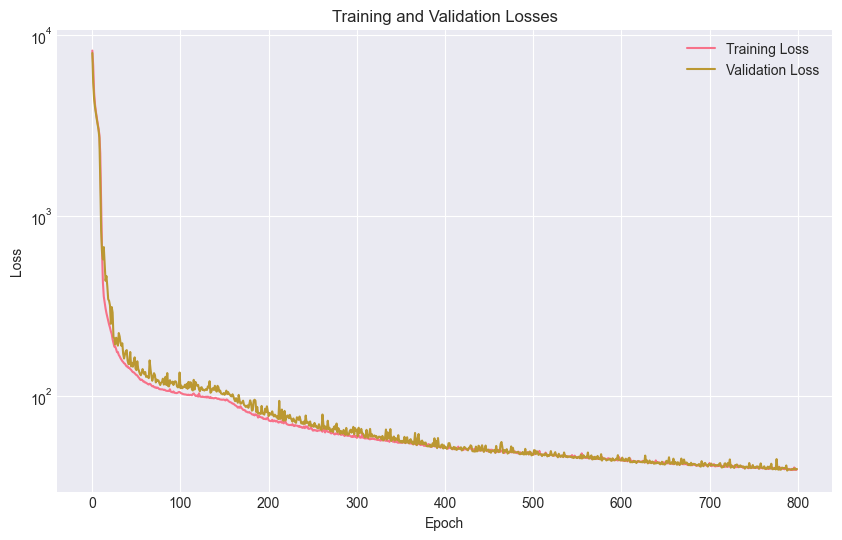

In [13]:
from src.util import resume_training

epochs = 800
start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)
# start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch800.pth', model, optimizer)

print(f"Resumed from epoch: {start_epoch}")
print(f"checkpoint_path: {checkpoint_path}")
plot_model_loss(training_losses, validation_losses)

<>:3: SyntaxWarning: invalid escape sequence '\R'
<>:3: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_2992\1411000874.py:3: SyntaxWarning: invalid escape sequence '\R'
  start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch1400.pth', model, optimizer)


Resumed training from epoch 1400
Resumed from epoch: 1400
checkpoint_path: checkpoint\RNN_VAE_lat16_hid128_gru4_norm_uncert_v20251213


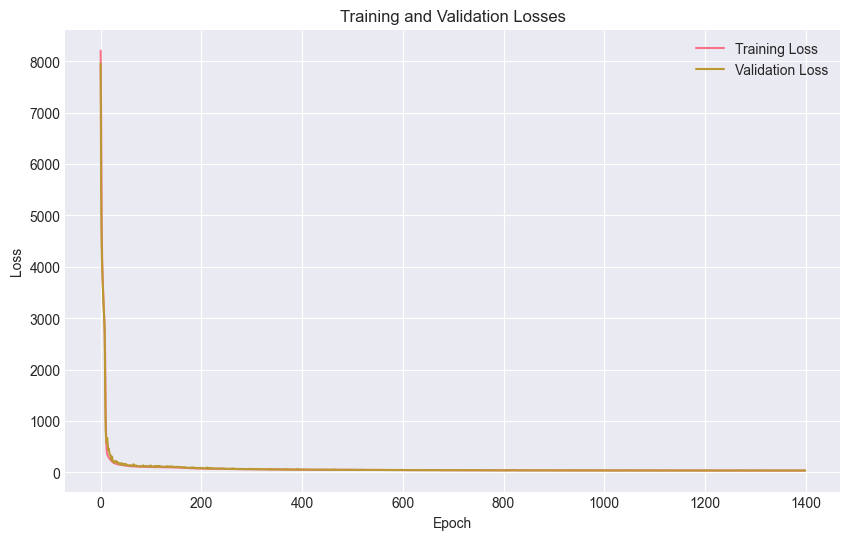

In [225]:
from src.util import resume_training

start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch1400.pth', model, optimizer)

print(f"Resumed from epoch: {start_epoch}")
print(f"checkpoint_path: {checkpoint_path}")
plot_model_loss(training_losses, validation_losses)

# re-training

<>:47: SyntaxWarning: invalid escape sequence '\R'
<>:47: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_2992\2248375125.py:47: SyntaxWarning: invalid escape sequence '\R'
  checkpoint_path_file = f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epoch+1}.pth'


start_epoch: 1400
Beginning training...
Epoch 1400 | Train: 34.87 | Val: 34.93
Epoch 1401 | Train: 34.91 | Val: 37.18
Epoch 1402 | Train: 35.27 | Val: 34.81
Epoch 1403 | Train: 34.77 | Val: 34.38
Epoch 1404 | Train: 34.52 | Val: 34.19
Epoch 1405 | Train: 34.59 | Val: 34.32
Epoch 1406 | Train: 34.49 | Val: 34.99
Epoch 1407 | Train: 34.55 | Val: 35.23
Epoch 1408 | Train: 34.24 | Val: 33.98
Epoch 1409 | Train: 34.39 | Val: 34.67
Epoch 1410 | Train: 34.39 | Val: 35.22
Epoch 1411 | Train: 34.39 | Val: 35.49
Epoch 1412 | Train: 34.33 | Val: 34.24
Epoch 1413 | Train: 35.00 | Val: 35.47
Epoch 1414 | Train: 35.58 | Val: 34.08
Epoch 1415 | Train: 34.40 | Val: 34.49
Epoch 1416 | Train: 34.57 | Val: 35.00
Epoch 1417 | Train: 34.34 | Val: 34.58
Epoch 1418 | Train: 34.31 | Val: 34.89
Epoch 1419 | Train: 34.57 | Val: 34.24
Checkpoint saved at epoch 1420 in the file: checkpoint\RNN_VAE_lat16_hid128_gru4_norm_uncert_v20251213\RNN_VAE_checkpoint_epoch1420.pth
Model checkpoint saved at checkpoint\RNN_VAE

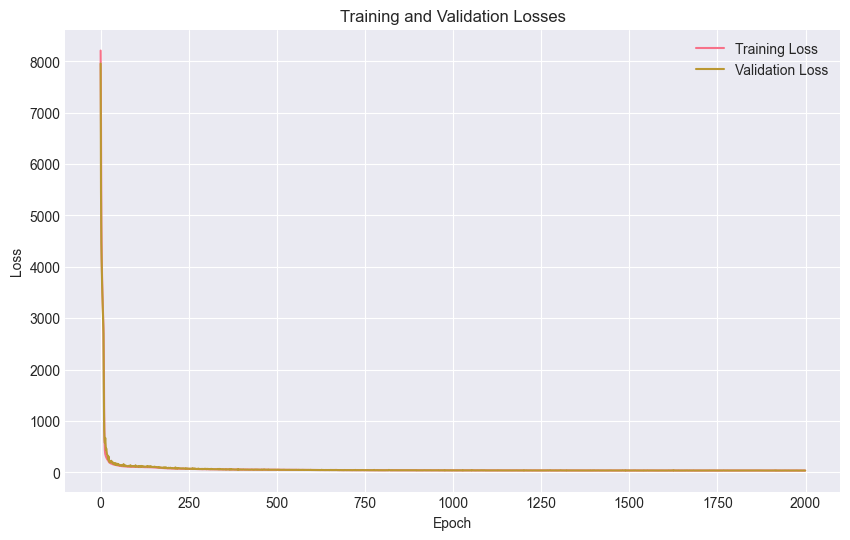

In [226]:
print(f"start_epoch: {start_epoch}")

# Continue training loop from start_epoch
print("Beginning training...")

for epoch in range(start_epoch, 2000):
    # set to training mode
    model.train()
    train_loss = 0
    
    for x, uncertainties, weights, labels, ids, lengths in train_loader:
        x = x.to(device)
        weights = weights.to(device)
        
        x_hat, mu, logvar = model(x, lengths)
        loss = uncertainty_weighted_ELBO(x_hat, x, mu, logvar, weights)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    training_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for x, uncertainties, weights, labels, ids, lengths in val_loader:
            x = x.to(device)
            weights = weights.to(device)
            
            x_hat, mu, logvar = model(x, lengths)
            loss = uncertainty_weighted_ELBO(x_hat, x, mu, logvar, weights)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    validation_losses.append(avg_val_loss)

    print(f'Epoch {epoch} | Train: {avg_train_loss:.2f} | Val: {avg_val_loss:.2f}')

        # Save model checkpoint every checkpoint_increment epochs
    if (epoch + 1) % checkpoint_increment == 0:
        checkpoint_path_file = f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epoch+1}.pth'
        save_checkpoint(epoch+1, model, optimizer, avg_train_loss, avg_val_loss, training_losses, validation_losses, path=checkpoint_path_file)
        print(f'Model checkpoint saved at {checkpoint_path_file}')

plot_model_loss(training_losses, validation_losses)


# Calculate latent space


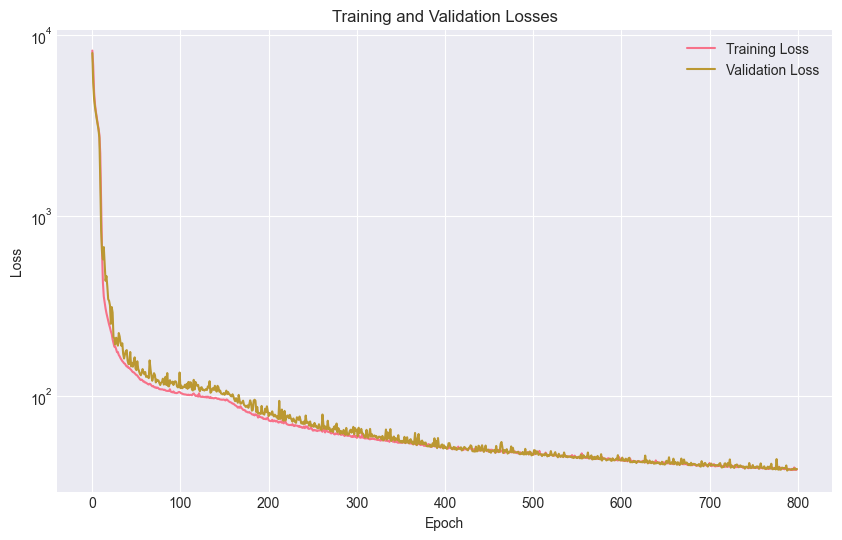

In [14]:
plot_model_loss(training_losses, validation_losses)


# Latent space analysis #1

k:\victor\python-project\torchenv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


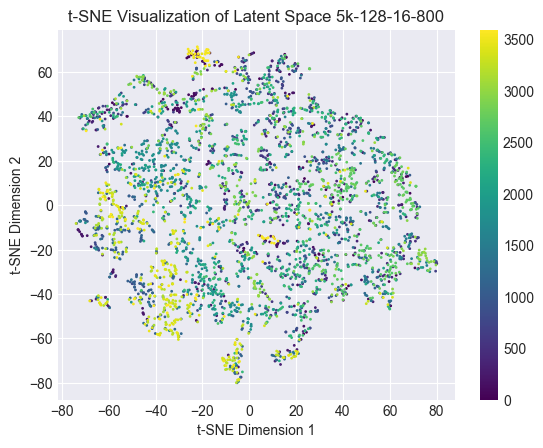

In [15]:
####### get latent features
# start_epoch = 600
import numpy as np
import torch.nn.utils.rnn as rnn

def get_clustered_data(model, data_loader):
  # Get latent representations for all data points
  with torch.no_grad():
    all_mus = []
    labels_latent = []

    for x, uncertainties, weights, labels, ids, lengths in data_loader:
        x = x.to(device)
        weights = weights.to(device)
        encoded, mu, logvar = model(x, lengths)
        all_mus.append(mu.to(device))
        labels_latent.append(labels.to(device))
        # print(labels)

    latent_data = torch.cat(all_mus, dim=0)
    latent_label = torch.cat(labels_latent, dim=0)

    return latent_data, latent_label


def tsne_transform(latent_space, latent_label):
  # Assuming you have a latent space representation in a NumPy array:

  # latent_space = X

  # Reduce dimensionality to 2D using t-SNE
  tsne = TSNE(n_components=2, perplexity=20, learning_rate=200, random_state=40, n_iter=1000)
  latent_space_2d = tsne.fit_transform(latent_space)


  # Plot the 2D representation
  plt.scatter(latent_space_2d[:, 0], latent_space_2d[:, 1], s=1, c=latent_label, cmap='viridis')
  plt.colorbar()

  plt.xlabel('t-SNE Dimension 1')
  plt.ylabel('t-SNE Dimension 2')
  plt.title(f't-SNE Visualization of Latent Space 5k-{hidden_size}-{latent_size}-{start_epoch}')

  plt.show()

# latent data
clustered_latent_data, clustered_latent_label = get_clustered_data(model, all_loader_no_shuffle)

X = clustered_latent_data.cpu().numpy()
latent_label = clustered_latent_label.cpu().numpy()
tsne_transform(X, latent_label)



# HDBSCAN #2
# optimize min_samples_range, fix min_cluster_size=10



min_samples=3 -> Found 2 anomalies (Score > 0.6)
min_samples=4 -> Found 6 anomalies (Score > 0.6)
min_samples=5 -> Found 21 anomalies (Score > 0.6)
min_samples=6 -> Found 99 anomalies (Score > 0.6)
min_samples=7 -> Found 51 anomalies (Score > 0.6)
min_samples=8 -> Found 135 anomalies (Score > 0.6)
min_samples=9 -> Found 139 anomalies (Score > 0.6)
min_samples=10 -> Found 33 anomalies (Score > 0.6)
min_samples=11 -> Found 158 anomalies (Score > 0.6)
min_samples=12 -> Found 145 anomalies (Score > 0.6)
min_samples=13 -> Found 164 anomalies (Score > 0.6)
min_samples=14 -> Found 162 anomalies (Score > 0.6)
min_samples=15 -> Found 170 anomalies (Score > 0.6)
min_samples=16 -> Found 153 anomalies (Score > 0.6)
min_samples=17 -> Found 178 anomalies (Score > 0.6)
min_samples=18 -> Found 169 anomalies (Score > 0.6)
min_samples=19 -> Found 193 anomalies (Score > 0.6)
min_samples=20 -> Found 183 anomalies (Score > 0.6)
min_samples=21 -> Found 194 anomalies (Score > 0.6)
min_samples=22 -> Found 175

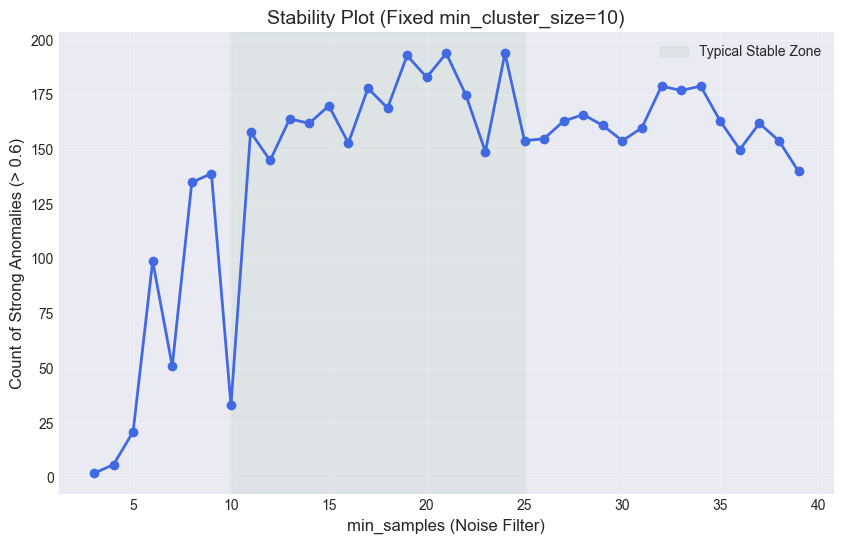

[(3, 2),
 (4, 6),
 (5, 21),
 (6, 99),
 (7, 51),
 (8, 135),
 (9, 139),
 (10, 33),
 (11, 158),
 (12, 145),
 (13, 164),
 (14, 162),
 (15, 170),
 (16, 153),
 (17, 178),
 (18, 169),
 (19, 193),
 (20, 183),
 (21, 194),
 (22, 175),
 (23, 149),
 (24, 194),
 (25, 154),
 (26, 155),
 (27, 163),
 (28, 166),
 (29, 161),
 (30, 154),
 (31, 160),
 (32, 179),
 (33, 177),
 (34, 179),
 (35, 163),
 (36, 150),
 (37, 162),
 (38, 154),
 (39, 140)]

In [16]:
import hdbscan
import numpy as np
import matplotlib.pyplot as plt
import warnings

def hdbscan_study_fixed_size(X, min_cluster_size=10, min_samples_range=range(3, 40)):
    """
    Runs HDBSCAN with a fixed min_cluster_size and varying min_samples.
    Returns the anomaly counts to help identify the 'Stability Plateau'.
    """
    warnings.filterwarnings('ignore')
    
    results = []
    
    # Iterate ONLY over min_samples
    for min_samples in min_samples_range:
        
        # 1. Initialize and Fit
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size, # FIXED at 10
            min_samples=min_samples,           # VARYING
            metric='euclidean',
            cluster_selection_method='eom', 
            allow_single_cluster=True
        )
        
        clusterer.fit(X)
        
        # 2. Calculate Anomalies (Robust Threshold Method)
        # We use a fixed scientific threshold (0.8) to see how the model behavior changes.
        # If we used a percentile (e.g. top 1%), the count would be constant, hiding the physics.
        scores = clusterer.outlier_scores_
        threshold = 0.60
        
        anomaly_indices = np.where(scores > threshold)[0]
        count = len(anomaly_indices)
        
        results.append((min_samples, count))
        print(f"min_samples={min_samples} -> Found {count} anomalies (Score > {threshold})")

    # Unpack for plotting
    x_vals = [r[0] for r in results]
    y_vals = [r[1] for r in results]

    # 3. Plot the Curve
    plt.figure(figsize=(10, 6))
    plt.plot(x_vals, y_vals, 'o-', linewidth=2, color='royalblue')
    
    # Add visual guide for the "Plateau"
    plt.xlabel('min_samples (Noise Filter)', fontsize=12)
    plt.ylabel(f'Count of Strong Anomalies (> {threshold})', fontsize=12)
    plt.title(f'Stability Plot (Fixed min_cluster_size={min_cluster_size})', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # Highlight the likely optimal zone (visual aid)
    plt.axvspan(10, 25, color='green', alpha=0.05, label='Typical Stable Zone')
    plt.legend()
    
    plt.show()
    
    return results

hdbscan_study_fixed_size(X)
# --- USAGE ---
# results = hdbscan_study_fixed_size(my_features, min_cluster_size=10)

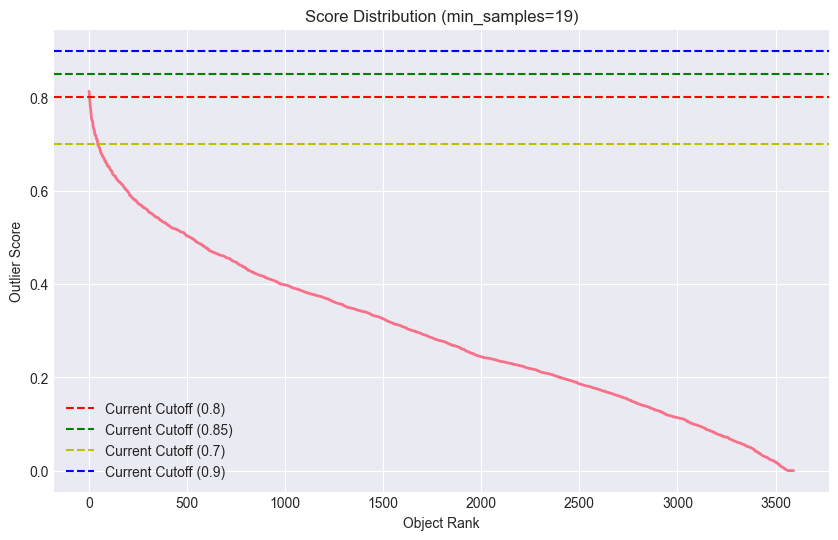

In [17]:
import matplotlib.pyplot as plt
import numpy as np

min_cluster_size=10 # FIXED at 10
min_samples = 21

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size, # FIXED at 10
    min_samples=min_samples,           # VARYING
    # metric='euclidean',
    cluster_selection_method='eom', 
    allow_single_cluster=True
)

clusterer.fit(X)
# Use your trained clusterer
scores = clusterer.outlier_scores_

# Sort scores high to low
sorted_scores = np.sort(scores)[::-1]

plt.figure(figsize=(10, 6))
plt.plot(sorted_scores, linewidth=2)
plt.axhline(y=0.8, color='r', linestyle='--', label='Current Cutoff (0.8)')
plt.axhline(y=0.85, color='g', linestyle='--', label='Current Cutoff (0.85)')
plt.axhline(y=0.7, color='y', linestyle='--', label='Current Cutoff (0.7)')
plt.axhline(y=0.9, color='b', linestyle='--', label='Current Cutoff (0.9)')
plt.ylabel("Outlier Score")
plt.xlabel("Object Rank")
plt.title("Score Distribution (min_samples=19)")
plt.legend()
plt.show()

In [18]:
threshold = 0.6

anomaly_indices = np.where(scores > threshold)[0]
# count = len(anomaly_indices)

print(f"""For min_samples = {min_samples}, min_cluster_size = {min_cluster_size}, threshold = {threshold}, epoch = {start_epoch}, the size of anomalies = {len(anomaly_indices)}""")
# print(anomaly_indices)
indices = np.array(latent_label[anomaly_indices]).flatten()
list2 = [int(i) for i in sorted(indices)]

# For min_samples = 12, min_cluster_size = 10, threshold = 0.8, epoch = 320, the size of anomalies = 173
# For min_samples = 25, min_cluster_size = 10, threshold = 0.8, epoch = 1000, the size of anomalies = 165

# For min_samples = 20, min_cluster_size = 10, threshold = 0.6, epoch = 600, the size of anomalies = 145
# For min_samples = 25, min_cluster_size = 10, threshold = 0.6, epoch = 500, the size of anomalies = 178



For min_samples = 21, min_cluster_size = 10, threshold = 0.6, epoch = 800, the size of anomalies = 194


In [306]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Create and fit the Isolation Forest model
# clf = IsolationForest(contamination=0.1)
clf = IsolationForest(contamination=0.09, n_estimators=1000, random_state=42)
clf.fit(X)

# Predict anomalies
y_pred = clf.predict(X)

indices_raw = np.where(y_pred == -1 )
indices = np.array(latent_label[indices_raw])
indices = indices.flatten()
print(len(indices))
print(sorted(indices))
print([int(i) for i in sorted(indices)])
list3 = [int(i) for i in sorted(indices)]

#  - 100
# [52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 110, 111, 112, 113, 119, 120, 124, 140, 141, 142, 146, 149, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 181, 200, 207, 209, 210, 211, 215, 217, 218, 221, 223, 224, 225, 226, 243, 247, 257, 296, 297, 298, 300, 304, 307, 308, 309, 313, 314, 344, 345, 352, 357, 361, 362, 367, 373, 477, 488, 591, 594, 597, 611, 615, 616, 618, 619, 627, 628, 630, 631, 633, 639, 648, 651, 656, 657, 663, 665, 768, 799, 965, 980, 991, 996, 1003, 1007, 1048, 1051, 1052, 1066, 1072, 1075, 1146, 1164, 1196, 1226, 1227, 1234, 1244, 1255, 1268, 1270, 1284, 1318, 1326, 1327, 1440, 1443, 1445, 1455, 1464, 1470, 1477, 1497, 1498, 1500, 1501, 1505, 1506, 1508, 1510, 1512, 1513, 1514, 1515, 1518, 1522, 1525, 1527, 1578, 1584, 1599, 1602, 1623, 1655, 1671, 1674, 1679, 1701, 1721, 1726, 1748, 1817, 1920, 1927, 1938, 1939, 1940, 1943, 1951, 1956, 1961, 1980, 1993, 2014, 2193, 2412, 2587, 2620, 2622, 2665, 2829, 2840, 2848, 2876, 2896, 2914, 2926, 2970, 2983, 2987, 3020, 3035, 3038, 3072, 3076, 3077, 3169, 3175, 3176, 3180, 3189, 3194, 3196, 3198, 3201, 3204, 3206, 3210, 3215, 3228, 3239, 3240, 3245, 3248, 3251, 3259, 3273, 3282, 3284, 3313, 3374, 3375, 3376, 3401, 3409, 3427, 3432, 3437, 3440, 3442, 3445, 3446, 3459, 3463, 3467, 3479, 3488, 3496, 3498, 3499, 3503, 3506, 3509, 3513, 3527, 3528, 3530, 3532, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3543, 3544, 3545, 3548, 3551, 3552, 3553, 3554, 3557, 3558, 3559, 3560, 3563, 3566, 3568, 3569]
# - 300
# [1, 2, 6, 10, 11, 14, 17, 19, 27, 33, 36, 52, 53, 57, 60, 62, 63, 66, 67, 68, 70, 71, 72, 79, 80, 82, 87, 116, 125, 129, 130, 134, 135, 148, 149, 153, 159, 175, 180, 181, 190, 193, 194, 197, 198, 199, 200, 201, 203, 206, 214, 215, 217, 224, 225, 226, 227, 243, 247, 252, 258, 259, 260, 267, 271, 278, 281, 284, 286, 288, 298, 300, 302, 307, 314, 315, 328, 329, 343, 346, 350, 352, 357, 367, 375, 378, 411, 422, 423, 427, 445, 484, 511, 521, 566, 581, 582, 586, 598, 601, 623, 645, 658, 661, 664, 688, 698, 704, 729, 735, 745, 751, 757, 763, 767, 769, 772, 776, 779, 785, 795, 809, 814, 818, 870, 881, 886, 888, 900, 918, 925, 960, 964, 968, 976, 991, 995, 998, 1000, 1002, 1008, 1025, 1030, 1039, 1053, 1062, 1085, 1100, 1115, 1139, 1164, 1175, 1184, 1191, 1227, 1234, 1244, 1255, 1270, 1271, 1284, 1305, 1306, 1310, 1314, 1329, 1357, 1397, 1408, 1417, 1421, 1423, 1467, 1485, 1490, 1508, 1514, 1526, 1532, 1542, 1552, 1572, 1588, 1630, 1632, 1637, 1641, 1642, 1719, 1731, 1739, 1746, 1758, 1783, 1785, 1832, 1844, 1869, 1888, 1892, 1893, 1902, 1906, 1930, 1932, 1933, 2028, 2039, 2062, 2098, 2207, 2208, 2214, 2215, 2228, 2242, 2254, 2266, 2279, 2280, 2286, 2297, 2307, 2311, 2312, 2323, 2325, 2326, 2336, 2350, 2352, 2360, 2363, 2381, 2382, 2398, 2399, 2422, 2433, 2447, 2460, 2471, 2473, 2477, 2481, 2484, 2489, 2490, 2509, 2519, 2521, 2526, 2528, 2529, 2530, 2539, 2569, 2585, 2586, 2587, 2596, 2597, 2599, 2665, 2703, 2724, 2726, 2834, 2837, 2853, 2881, 2892, 2968, 2976, 2977, 3007, 3057, 3065, 3070, 3121, 3135, 3175, 3180, 3181, 3187, 3194, 3196, 3203, 3207, 3210, 3215, 3216, 3237, 3239, 3242, 3251, 3256, 3262, 3271, 3282, 3287, 3301, 3311, 3319, 3327, 3348, 3352, 3359, 3362, 3392, 3396, 3398, 3406, 3421, 3427, 3451, 3460, 3467, 3530, 3541, 3555, 3569, 3588, 3592]
# - 600
# [2, 6, 14, 17, 34, 36, 44, 52, 53, 54, 58, 63, 65, 70, 80, 82, 116, 125, 130, 134, 135, 146, 148, 149, 159, 162, 166, 168, 176, 189, 193, 194, 195, 197, 198, 199, 200, 201, 202, 203, 214, 215, 217, 220, 222, 225, 226, 252, 259, 278, 279, 284, 298, 300, 301, 302, 305, 314, 323, 326, 328, 331, 343, 346, 349, 350, 352, 367, 423, 427, 445, 454, 468, 469, 484, 518, 521, 534, 543, 566, 581, 586, 594, 601, 605, 623, 629, 636, 645, 649, 658, 661, 664, 667, 688, 703, 705, 729, 734, 735, 757, 763, 766, 785, 795, 814, 818, 826, 869, 881, 888, 900, 948, 964, 968, 991, 995, 1027, 1066, 1074, 1077, 1085, 1100, 1115, 1116, 1119, 1124, 1126, 1140, 1144, 1155, 1163, 1164, 1169, 1186, 1187, 1191, 1198, 1214, 1215, 1218, 1225, 1227, 1231, 1233, 1234, 1244, 1255, 1257, 1266, 1268, 1271, 1274, 1276, 1284, 1306, 1331, 1357, 1369, 1397, 1403, 1408, 1417, 1467, 1478, 1485, 1509, 1526, 1536, 1538, 1542, 1543, 1552, 1554, 1588, 1631, 1637, 1642, 1676, 1731, 1745, 1769, 1849, 1888, 1897, 1932, 1933, 2027, 2039, 2098, 2167, 2214, 2215, 2228, 2254, 2276, 2280, 2286, 2311, 2312, 2323, 2333, 2341, 2345, 2350, 2355, 2359, 2382, 2394, 2397, 2398, 2399, 2407, 2417, 2422, 2429, 2447, 2471, 2477, 2489, 2496, 2502, 2504, 2519, 2526, 2528, 2529, 2530, 2585, 2586, 2587, 2665, 2703, 2714, 2825, 2835, 2846, 2849, 2851, 2852, 2853, 2858, 2877, 2881, 2883, 2884, 2885, 2888, 2892, 2899, 2901, 2908, 2914, 2924, 2968, 2973, 2976, 2977, 2991, 3013, 3019, 3026, 3041, 3046, 3050, 3051, 3057, 3063, 3065, 3126, 3135, 3148, 3169, 3191, 3207, 3214, 3215, 3216, 3229, 3230, 3237, 3239, 3241, 3246, 3253, 3256, 3261, 3262, 3267, 3274, 3287, 3311, 3314, 3319, 3327, 3330, 3334, 3338, 3341, 3348, 3352, 3357, 3359, 3362, 3368, 3382, 3396, 3398, 3401, 3408, 3421, 3423, 3426, 3427, 3432, 3437, 3443, 3449, 3451, 3460, 3464, 3519, 3530, 3569]


324
[np.int64(2), np.int64(6), np.int64(14), np.int64(17), np.int64(34), np.int64(36), np.int64(41), np.int64(44), np.int64(52), np.int64(63), np.int64(66), np.int64(70), np.int64(79), np.int64(80), np.int64(116), np.int64(130), np.int64(134), np.int64(135), np.int64(148), np.int64(149), np.int64(159), np.int64(189), np.int64(193), np.int64(194), np.int64(197), np.int64(198), np.int64(201), np.int64(203), np.int64(214), np.int64(215), np.int64(216), np.int64(217), np.int64(222), np.int64(225), np.int64(226), np.int64(252), np.int64(259), np.int64(269), np.int64(274), np.int64(278), np.int64(279), np.int64(284), np.int64(298), np.int64(300), np.int64(301), np.int64(302), np.int64(305), np.int64(310), np.int64(314), np.int64(323), np.int64(326), np.int64(328), np.int64(331), np.int64(343), np.int64(346), np.int64(349), np.int64(352), np.int64(411), np.int64(427), np.int64(445), np.int64(454), np.int64(468), np.int64(469), np.int64(483), np.int64(484), np.int64(518), np.int64(521), np.int

In [76]:

list2aa = [2, 6, 14, 17, 36, 37, 52, 53, 54, 58, 63, 65, 66, 70, 78, 79, 80, 82, 87, 90, 116, 125, 130, 134, 135, 146, 148, 149, 153, 159, 168, 171, 176, 180, 189, 190, 193, 194, 195, 197, 198, 199, 200, 201, 202, 203, 207, 214, 215, 217, 219, 220, 221, 222, 225, 226, 252, 259, 271, 278, 284, 288, 298, 300, 302, 305, 314, 323, 328, 329, 331, 343, 346, 350, 352, 367, 378, 411, 422, 423, 427, 433, 445, 469, 484, 511, 521, 533, 534, 566, 569, 581, 582, 586, 591, 594, 601, 605, 611, 623, 629, 636, 645, 658, 661, 664, 667, 688, 691, 703, 723, 734, 735, 757, 763, 766, 768, 785, 795, 799, 814, 818, 869, 881, 884, 888, 900, 918, 925, 941, 964, 966, 968, 991, 995, 998, 1009, 1022, 1062, 1066, 1072, 1074, 1077, 1085, 1099, 1100, 1115, 1116, 1121, 1126, 1135, 1140, 1144, 1163, 1164, 1170, 1187, 1191, 1198, 1201, 1214, 1215, 1227, 1234, 1244, 1255, 1257, 1266, 1271, 1276, 1284, 1306, 1310, 1331, 1357, 1369, 1383, 1397, 1403, 1408, 1417, 1423, 1467, 1476, 1485, 1508, 1509, 1512, 1526, 1528, 1532, 1536, 1542, 1552, 1554, 1562, 1588, 1591, 1630, 1632, 1637, 1642, 1731, 1739, 1745, 1849, 1888, 1902, 1932, 1933, 2039, 2098, 2110, 2164, 2214, 2215, 2228, 2254, 2280, 2286, 2311, 2312, 2323, 2326, 2345, 2350, 2355, 2359, 2382, 2398, 2399, 2422, 2447, 2471, 2473, 2477, 2489, 2490, 2502, 2504, 2519, 2521, 2526, 2528, 2529, 2530, 2569, 2585, 2586, 2587, 2597, 2665, 2703, 2835, 2846, 2849, 2851, 2853, 2877, 2881, 2882, 2883, 2884, 2885, 2892, 2901, 2914, 2924, 2968, 2973, 2976, 2977, 2993, 3013, 3019, 3031, 3051, 3057, 3063, 3065, 3070, 3135, 3169, 3191, 3207, 3216, 3229, 3237, 3239, 3241, 3246, 3256, 3287, 3301, 3311, 3319, 3334, 3338, 3352, 3359, 3398, 3401, 3406, 3408, 3421, 3423, 3426, 3427, 3428, 3432, 3436, 3437, 3445, 3449, 3451, 3460, 3464, 3467, 3527, 3530, 3534, 3553, 3569, 3592]
list2aa = [2, 6, 14, 17, 34, 36, 44, 52, 53, 54, 58, 63, 65, 70, 80, 82, 116, 125, 130, 134, 135, 146, 148, 149, 159, 162, 166, 168, 176, 189, 193, 194, 195, 197, 198, 199, 200, 201, 202, 203, 214, 215, 217, 220, 222, 225, 226, 252, 259, 278, 279, 284, 298, 300, 301, 302, 305, 314, 323, 326, 328, 331, 343, 346, 349, 350, 352, 367, 423, 427, 445, 454, 468, 469, 484, 518, 521, 534, 543, 566, 581, 586, 594, 601, 605, 623, 629, 636, 645, 649, 658, 661, 664, 667, 688, 703, 705, 729, 734, 735, 757, 763, 766, 785, 795, 814, 818, 826, 869, 881, 888, 900, 948, 964, 968, 991, 995, 1027, 1066, 1074, 1077, 1085, 1100, 1115, 1116, 1119, 1124, 1126, 1140, 1144, 1155, 1163, 1164, 1169, 1186, 1187, 1191, 1198, 1214, 1215, 1218, 1225, 1227, 1231, 1233, 1234, 1244, 1255, 1257, 1266, 1268, 1271, 1274, 1276, 1284, 1306, 1331, 1357, 1369, 1397, 1403, 1408, 1417, 1467, 1478, 1485, 1509, 1526, 1536, 1538, 1542, 1543, 1552, 1554, 1588, 1631, 1637, 1642, 1676, 1731, 1745, 1769, 1849, 1888, 1897, 1932, 1933, 2027, 2039, 2098, 2167, 2214, 2215, 2228, 2254, 2276, 2280, 2286, 2311, 2312, 2323, 2333, 2341, 2345, 2350, 2355, 2359, 2382, 2394, 2397, 2398, 2399, 2407, 2417, 2422, 2429, 2447, 2471, 2477, 2489, 2496, 2502, 2504, 2519, 2526, 2528, 2529, 2530, 2585, 2586, 2587, 2665, 2703, 2714, 2825, 2835, 2846, 2849, 2851, 2852, 2853, 2858, 2877, 2881, 2883, 2884, 2885, 2888, 2892, 2899, 2901, 2908, 2914, 2924, 2968, 2973, 2976, 2977, 2991, 3013, 3019, 3026, 3041, 3046, 3050, 3051, 3057, 3063, 3065, 3126, 3135, 3148, 3169, 3191, 3207, 3214, 3215, 3216, 3229, 3230, 3237, 3239, 3241, 3246, 3253, 3256, 3261, 3262, 3267, 3274, 3287, 3311, 3314, 3319, 3327, 3330, 3334, 3338, 3341, 3348, 3352, 3357, 3359, 3362, 3368, 3382, 3396, 3398, 3401, 3408, 3421, 3423, 3426, 3427, 3432, 3437, 3443, 3449, 3451, 3460, 3464, 3519, 3530, 3569]
list3aa = [1, 2, 6, 11, 12, 14, 17, 23, 27, 29, 36, 37, 51, 52, 60, 63, 93, 94, 117, 127, 130, 135, 136, 146, 149, 150, 153, 156, 159, 161, 169, 173, 178, 179, 181, 186, 187, 193, 196, 197, 199, 200, 202, 206, 207, 208, 209, 210, 211, 215, 217, 223, 224, 226, 234, 236, 237, 249, 250, 255, 256, 257, 260, 261, 262, 265, 269, 270, 276, 278, 284, 285, 286, 293, 294, 295, 296, 299, 302, 303, 305, 311, 312, 315, 319, 321, 324, 325, 326, 328, 329, 330, 333, 341, 343, 344, 352, 356, 369, 371, 372, 373, 375, 378, 386, 391, 403, 406, 407, 410, 411, 418, 420, 422, 423, 427, 428, 430, 431, 433, 439, 445, 447, 452, 453, 454, 458, 468, 470, 481, 486, 489, 496, 497, 502, 515, 521, 524, 526, 533, 534, 543, 546, 553, 560, 566, 567, 577, 581, 583, 586, 595, 596, 601, 603, 620, 621, 624, 625, 634, 635, 641, 645, 648, 649, 651, 658, 661, 671, 675, 691, 695, 699, 701, 705, 710, 728, 729, 730, 735, 757, 779, 785, 812, 814, 825, 995, 996, 1008, 1029, 1054, 1062, 1063, 1083, 1087, 1129, 1138, 1188, 1200, 1201, 1213, 1219, 1228, 1234, 1236, 1240, 1246, 1252, 1278, 1285, 1291, 1308, 1312, 1319, 1323, 1330, 1331, 1337, 1339, 1346, 1357, 1358, 1362, 1367, 1369, 1370, 1378, 1384, 1392, 1395, 1398, 1399, 1407, 1409, 1410, 1422, 1423, 1424, 1425, 1429, 1435, 1437, 1454, 1464, 1476, 1487, 1492, 1493, 1510, 1519, 1527, 1528, 1550, 1555, 1582, 1590, 1716, 1760, 1822, 1835, 1856, 1858, 1863, 1865, 1885, 1971, 2032, 2033, 2043, 2062, 2175, 2260, 2264, 2286, 2326, 2348, 2371, 2375, 2378, 2386, 2387, 2396, 2415, 2461, 2483, 2489, 2495, 2508, 2538, 2542, 2543, 2544, 2545, 2559, 2562, 2570, 2588, 2596, 2597, 2599, 2608, 2614, 2615, 2616, 2628, 2638, 2644, 2646, 2693, 2695, 2700, 2733, 2756, 2761, 2849, 3001, 3056, 3076, 3096, 3097, 3408, 3435, 3442, 3463, 3550, 3570, 3613]
# norm / standard
set_alll = set.intersection(*(set(lst) for lst in [list2aa, list3aa, anomaly_indices]))
set_alll = set.intersection(*(set(lst) for lst in [list2aa, anomaly_indices]))

print(len(set_alll))

# 40
# 70
# 59


21


In [307]:
set_all = set.intersection(*(set(lst) for lst in [list2, list3]))

print(len(set_all))
print(sorted(set_all))
print(sorted([all_labels[sub_index] for sub_index in set_all]))
anomaly_names = sorted([all_labels[sub_index] for sub_index in set_all])


# 165
# [1, 2, 12, 36, 37, 51, 52, 135, 146, 149, 150, 153, 156, 159, 169, 173, 178, 181, 186, 187, 196, 197, 199, 200, 208, 223, 236, 249, 255, 256, 257, 260, 261, 262, 269, 270, 284, 285, 286, 294, 295, 296, 299, 312, 315, 321, 325, 326, 328, 329, 330, 333, 343, 352, 356, 369, 371, 372, 410, 411, 420, 422, 430, 431, 439, 447, 452, 497, 526, 533, 534, 543, 546, 553, 577, 586, 601, 603, 621, 634, 635, 641, 648, 649, 658, 671, 675, 691, 695, 699, 728, 729, 757, 779, 785, 812, 825, 995, 996, 1008, 1029, 1054, 1087, 1129, 1138, 1201, 1213, 1228, 1236, 1252, 1278, 1285, 1291, 1308, 1323, 1330, 1358, 1378, 1395, 1398, 1409, 1410, 1422, 1429, 1435, 1437, 1487, 1519, 1527, 1550, 1555, 1582, 1716, 1822, 1835, 1856, 1858, 1863, 1971, 2033, 2062, 2260, 2264, 2348, 2371, 2387, 2461, 2483, 2508, 2543, 2544, 2570, 2596, 2597, 2599, 2695, 2700, 2756, 2761, 2849, 3076, 3435, 3442, 3463, 3613]
# ['2018emt', '2018eny', '2018fbm', '2018fxj', '2018fxl', '2018gty', '2018gum', '2018jms', '2018jwi', '2018kao', '2018kbi', '2018kfv', '2018kif', '2018kjp', '2018kuv', '2018kwm', '2018lla', '2018lot', '2019abb', '2019abc', '2019ait', '2019ajf', '2019alb', '2019alj', '2019atc', '2019bfd', '2019bvp', '2019cjz', '2019con', '2019cow', '2019coz', '2019crx', '2019crz', '2019cwr', '2019dfr', '2019dhm', '2019dtv', '2019dut', '2019dzc', '2019ehx', '2019ekk', '2019ekn', '2019esa', '2019gdy', '2019gqv', '2019gws', '2019hit', '2019hlb', '2019hnp', '2019hpg', '2019hsc', '2019hyu', '2019iiv', '2019kli', '2019krj', '2019lph', '2019lpr', '2019lpw', '2019mpq', '2019mqc', '2019muu', '2019mzo', '2019njr', '2019njy', '2019nty', '2019nwu', '2019nzq', '2019pla', '2019qck', '2019qey', '2019qgh', '2019qoj', '2019qqk', '2019qty', '2019rre', '2019saz', '2019sld', '2019slj', '2019sqo', '2019sxb', '2019sxc', '2019tat', '2019til', '2019tjl', '2019tlu', '2019tsy', '2019tvu', '2019uge', '2019uje', '2019ukb', '2019vyb', '2019vyf', '2019xe', '2019zsi', '2020aacy', '2020aayc', '2020abfo', '2020afq', '2020akf', '2020aoi', '2020bbt', '2020bjq', '2020bxc', '2020ddu', '2020dnf', '2020fcw', '2020fjs', '2020fqv', '2020ftl', '2020gbb', '2020hhc', '2020hij', '2020hlh', '2020hvq', '2020ilw', '2020ish', '2020jxq', '2020kq', '2020lfw', '2020liy', '2020lpz', '2020lqd', '2020mfz', '2020mqq', '2020mtr', '2020mud', '2020ocw', '2020ptv', '2020qir', '2020rtt', '2020rxo', '2020tgq', '2020wd', '2020xyw', '2020yf', '2020ywq', '2020ywu', '2020yyt', '2021aaxr', '2021abwn', '2021acyl', '2021ageo', '2021agfn', '2021cby', '2021cya', '2021djx', '2021gbp', '2021hcx', '2021ife', '2021kky', '2021klj', '2021muw', '2021nwt', '2021nwu', '2021oim', '2021soz', '2021stc', '2021udg', '2021uef', '2021wkx', '2021yzg', '2022efb', '2022eg', '2022emm', '2022sr']

# 133 -- 
# [2, 6, 36, 52, 53, 63, 66, 70, 80, 87, 116, 125, 134, 135, 148, 149, 159, 197, 200, 214, 215, 217, 225, 226, 252, 259, 278, 298, 300, 305, 314, 323, 326, 328, 343, 350, 352, 367, 427, 445, 484, 521, 586, 601, 623, 667, 688, 735, 757, 785, 814, 818, 881, 968, 991, 995, 1074, 1077, 1085, 1100, 1115, 1116, 1163, 1164, 1187, 1234, 1244, 1255, 1266, 1271, 1306, 1331, 1357, 1417, 1485, 1542, 1642, 1731, 1888, 1932, 2039, 2098, 2214, 2215, 2228, 2280, 2311, 2312, 2345, 2350, 2355, 2382, 2422, 2489, 2519, 2529, 2530, 2585, 2587, 2665, 2714, 2846, 2851, 2853, 2881, 2892, 2901, 2976, 2977, 3019, 3050, 3057, 3063, 3065, 3135, 3169, 3216, 3237, 3246, 3256, 3319, 3327, 3334, 3352, 3359, 3362, 3401, 3421, 3427, 3432, 3437, 3460, 3530]
# ['2018eny', '2018eph', '2018fxj', '2018gum', '2018gxi', '2018hib', '2018hka', '2018hkx', '2018hql', '2018huc', '2018izr', '2018jgq', '2018jkg', '2018jms', '2018kah', '2018kao', '2018kjp', '2019ajf', '2019alj', '2019bap', '2019bcp', '2019bea', '2019bgo', '2019bgp', '2019cmb', '2019cqi', '2019dns', '2019erz', '2019esl', '2019fis', '2019gn', '2019gzu', '2019hlb', '2019hnp', '2019iiv', '2019kh', '2019kli', '2019lo', '2019nfv', '2019nvm', '2019pco', '2019pzj', '2019saz', '2019sld', '2019sse', '2019tsu', '2019ufy', '2019vzy', '2019xe', '2020aacy', '2020aayk', '2020abbx', '2020acpv', '2020aem', '2020aewf', '2020afq', '2020btp', '2020bvg', '2020bxc', '2020chm', '2020csx', '2020cxd', '2020dyu', '2020dzi', '2020eyb', '2020ftl', '2020fyf', '2020ghu', '2020hef', '2020hgp', '2020hvq', '2020iwn', '2020kav', '2020mez', '2020ocw', '2020rkb', '2020uvg', '2020wnf', '2020zo', '2021aalc', '2021acet', '2021adsn', '2021afte', '2021afth', '2021afvw', '2021agoa', '2021bll', '2021bma', '2021cmf', '2021css', '2021cxp', '2021dvt', '2021flg', '2021ieq', '2021kei', '2021kox', '2021ksl', '2021qpb', '2021qxb', '2021soz', '2021ttz', '2021xet', '2021xgy', '2021xhf', '2021xmj', '2021xob', '2021xpn', '2021yib', '2021yic', '2021yuh', '2021zba', '2021zco', '2021zeu', '2021zf', '2022amx', '2022bbk', '2022bzq', '2022cdv', '2022cfp', '2022chy', '2022djv', '2022dma', '2022dnw', '2022dsv', '2022dtp', '2022duk', '2022efc', '2022ejx', '2022emm', '2022eoa', '2022eqe', '2022ezj', '2022kh']

# 169
# [2, 6, 36, 52, 53, 58, 63, 66, 70, 78, 80, 82, 87, 116, 134, 135, 146, 149, 153, 159, 197, 200, 214, 215, 217, 220, 222, 225, 226, 252, 259, 271, 278, 288, 298, 300, 305, 314, 323, 328, 329, 331, 343, 350, 352, 367, 378, 411, 422, 427, 433, 445, 484, 521, 586, 601, 623, 645, 667, 688, 735, 757, 763, 785, 814, 818, 881, 925, 964, 968, 991, 995, 1062, 1066, 1074, 1077, 1085, 1099, 1100, 1115, 1116, 1163, 1164, 1170, 1187, 1191, 1227, 1234, 1244, 1255, 1257, 1266, 1271, 1331, 1357, 1397, 1408, 1417, 1423, 1485, 1542, 1554, 1562, 1591, 1642, 1731, 1745, 1932, 2039, 2098, 2214, 2215, 2228, 2280, 2311, 2312, 2345, 2350, 2355, 2382, 2398, 2422, 2447, 2489, 2490, 2519, 2521, 2529, 2530, 2569, 2585, 2587, 2665, 2846, 2853, 2877, 2881, 2883, 2884, 2892, 2901, 2973, 2976, 2977, 2993, 3019, 3051, 3057, 3065, 3135, 3191, 3207, 3216, 3237, 3246, 3256, 3287, 3319, 3334, 3352, 3359, 3401, 3406, 3421, 3427, 3460, 3467, 3530, 3592]
# ['2018eny', '2018eph', '2018fxj', '2018gum', '2018gxi', '2018hdo', '2018hib', '2018hka', '2018hkx', '2018hps', '2018hql', '2018hsf', '2018huc', '2018izr', '2018jkg', '2018jms', '2018jwi', '2018kao', '2018kfv', '2018kjp', '2019ajf', '2019alj', '2019bap', '2019bcp', '2019bea', '2019bet', '2019bfb', '2019bgo', '2019bgp', '2019cmb', '2019cqi', '2019dhz', '2019dns', '2019ebe', '2019erz', '2019esl', '2019fis', '2019gn', '2019gzu', '2019hnp', '2019hpg', '2019htx', '2019iiv', '2019kh', '2019kli', '2019lo', '2019lru', '2019mqc', '2019mzo', '2019nfv', '2019nng', '2019nvm', '2019pco', '2019pzj', '2019saz', '2019sld', '2019sse', '2019tfd', '2019tsu', '2019ufy', '2019vzy', '2019xe', '2019yek', '2020aacy', '2020aayk', '2020abbx', '2020acpv', '2020adw', '2020aek', '2020aem', '2020aewf', '2020afq', '2020bmp', '2020bol', '2020btp', '2020bvg', '2020bxc', '2020chi', '2020chm', '2020csx', '2020cxd', '2020dyu', '2020dzi', '2020eee', '2020eyb', '2020ezz', '2020fra', '2020ftl', '2020fyf', '2020ghu', '2020gzr', '2020hef', '2020hgp', '2020iwn', '2020kav', '2020lkf', '2020lqd', '2020mez', '2020mic', '2020ocw', '2020rkb', '2020rxw', '2020si', '2020tn', '2020uvg', '2020wnf', '2020wvh', '2021aalc', '2021acet', '2021adsn', '2021afte', '2021afth', '2021afvw', '2021agoa', '2021bll', '2021bma', '2021cmf', '2021css', '2021cxp', '2021dvt', '2021efn', '2021flg', '2021gfy', '2021ieq', '2021ife', '2021kei', '2021kil', '2021kox', '2021ksl', '2021odw', '2021qpb', '2021qxb', '2021soz', '2021xet', '2021xhf', '2021xku', '2021xmj', '2021xnb', '2021xni', '2021xob', '2021xpn', '2021yhc', '2021yib', '2021yic', '2021ylu', '2021yuh', '2021zbt', '2021zco', '2021zf', '2022amx', '2022blz', '2022bwe', '2022bzq', '2022cdv', '2022cfp', '2022chy', '2022csi', '2022djv', '2022dnw', '2022dsv', '2022dtp', '2022efc', '2022eg', '2022ejx', '2022emm', '2022ezj', '2022fdw', '2022kh', '2022zr']



127
[2, 6, 17, 36, 52, 63, 66, 70, 80, 116, 134, 135, 149, 159, 197, 214, 215, 216, 217, 225, 226, 252, 259, 278, 298, 300, 314, 323, 326, 328, 343, 346, 349, 352, 411, 427, 445, 484, 521, 586, 601, 623, 667, 688, 735, 757, 785, 814, 818, 881, 968, 991, 995, 1077, 1085, 1100, 1234, 1244, 1255, 1266, 1271, 1306, 1357, 1417, 1478, 1485, 1526, 1542, 1642, 1731, 1888, 1932, 2039, 2098, 2214, 2215, 2228, 2280, 2311, 2312, 2345, 2350, 2355, 2382, 2422, 2447, 2489, 2519, 2529, 2530, 2585, 2587, 2665, 2714, 2846, 2851, 2853, 2881, 2883, 2892, 2901, 2914, 2976, 2977, 3019, 3046, 3065, 3135, 3169, 3216, 3237, 3256, 3287, 3319, 3327, 3334, 3348, 3358, 3359, 3362, 3421, 3426, 3427, 3432, 3437, 3460, 3530]
['2018eny', '2018eph', '2018fhw', '2018fxj', '2018gum', '2018hib', '2018hka', '2018hkx', '2018hql', '2018izr', '2018jkg', '2018jms', '2018kao', '2018kjp', '2019ajf', '2019bap', '2019bcp', '2019bcu', '2019bea', '2019bgo', '2019bgp', '2019cmb', '2019cqi', '2019dns', '2019erz', '2019esl', '2019gn', 

# Re Construction Error Anomaly Detection

In [ ]:


def detect_anomalies_with_weights_b1(model, data_loader, threshold_percentile=95, device='cuda'):
    """
    Detect anomalies based on weighted reconstruction error
    Weights are per time step (batch_size, seq_len), not per feature
    """
    model.eval()
    all_recon_errors = []
    all_ids = []
    all_labels = []
    
    with torch.no_grad():
        for x, uncertainties, weights, labels, ids, lengths in data_loader:
            x = x.to(device)
            
            # Get reconstruction
            x_hat, mu, logvar = model(x, lengths)
            
            # Compute reconstruction error per time step and feature
            # (batch_size, seq_len, features)
            squared_error = (x_hat - x) ** 2
            
            # Handle weights - they are per time step
            if weights is not None:
                # Weights have shape (batch_size, seq_len)
                # We need to expand to match (batch_size, seq_len, features)
                weights = weights.to(device)
                
                # Add feature dimension and expand to match x shape
                weights_expanded = weights.unsqueeze(-1)  # (batch_size, seq_len, 1)
                weights_expanded = weights_expanded.expand_as(x)  # (batch_size, seq_len, features)
                
                # Apply weights to squared error
                weighted_error = weights_expanded * squared_error
            else:
                weighted_error = squared_error
            
            # Average across time steps and features for each sample
            # This gives one reconstruction error score per sample
            recon_error = torch.mean(weighted_error, dim=(1, 2)).cpu().numpy()
            
            all_recon_errors.extend(recon_error)
            all_ids.extend(ids)
            all_labels.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    all_recon_errors = np.array(all_recon_errors)
    
    # Set threshold based on percentile
    threshold = np.percentile(all_recon_errors, threshold_percentile)
    
    # Identify anomalies
    is_anomaly = all_recon_errors > threshold
    
    # Create results dictionary
    results = {
        'ids': all_ids,
        'reconstruction_errors': all_recon_errors,
        'anomaly_predictions': is_anomaly,
        'threshold': threshold,
        'labels': all_labels,
        'threshold_percentile': threshold_percentile
    }
    
    return results


def detect_anomalies_with_weights(model, data_loader, threshold_percentile=95, device='cuda'):
    """
    Detect anomalies based on weighted reconstruction error
    Weights are per time step (batch_size, seq_len), not per feature
    """
    model.eval()
    all_recon_errors = []
    all_ids = []
    all_labels = []
    all_original_data = []
    all_reconstructed_data = []
    all_sequence_lengths = []
    # all_weights = []
    
    # max_seq_len = 58  # Assuming this is your fixed padding length
    max_seq_len = max([all_data[item].shape[0] for item in range(len(all_data))])

    with torch.no_grad():
        for x, uncertainties, weights, labels, ids, lengths in data_loader:
            x = x.to(device)
            
            # Get reconstruction
            x_hat, mu, logvar = model(x, lengths)
            
            # Store original and reconstructed data
            original_batch = x.cpu().numpy()
            reconstructed_batch = x_hat.cpu().numpy()

            # Ensure all sequences have the same length (58)
            # They should already be padded by DataLoader
            batch_size = original_batch.shape[0]
            if original_batch.shape[1] != max_seq_len:
                # Pad or truncate to max_seq_len
                padded_original = np.zeros((batch_size, max_seq_len, original_batch.shape[2]))
                padded_reconstructed = np.zeros((batch_size, max_seq_len, reconstructed_batch.shape[2]))
                
                for i in range(batch_size):
                    seq_len = min(original_batch.shape[1], max_seq_len)
                    padded_original[i, :seq_len] = original_batch[i, :seq_len]
                    padded_reconstructed[i, :seq_len] = reconstructed_batch[i, :seq_len]
                
                original_batch = padded_original
                reconstructed_batch = padded_reconstructed

            # Compute reconstruction error per time step and feature
            # (batch_size, seq_len, features)
            squared_error = (x_hat - x) ** 2
            
            # Handle weights - they are per time step
            if weights is not None:
                # Weights have shape (batch_size, seq_len)
                # We need to expand to match (batch_size, seq_len, features)
                weights = weights.to(device)
                
                # Add feature dimension and expand to match x shape
                weights_expanded = weights.unsqueeze(-1)  # (batch_size, seq_len, 1)
                weights_expanded = weights_expanded.expand_as(x)  # (batch_size, seq_len, features)
                
                # Apply weights to squared error
                weighted_error = weights_expanded * squared_error
            else:
                weighted_error = squared_error
            
            # Average across time steps and features for each sample
            # This gives one reconstruction error score per sample
            recon_error = torch.mean(weighted_error, dim=(1, 2)).cpu().numpy()
            
            all_recon_errors.extend(recon_error)
            all_ids.extend(ids)
            all_labels.extend(labels.cpu().numpy())

            all_original_data.extend(original_batch)
            all_reconstructed_data.extend(reconstructed_batch)
            all_sequence_lengths.extend(lengths.cpu().numpy())

    
    # Convert to numpy arrays
    all_recon_errors = np.array(all_recon_errors)
    all_original_data = np.array(all_original_data)
    all_reconstructed_data = np.array(all_reconstructed_data)
    all_sequence_lengths = np.array(all_sequence_lengths)
    all_labels = np.array(all_labels)

    # Set threshold based on percentile
    threshold = np.percentile(all_recon_errors, threshold_percentile)
    
    # Identify anomalies
    is_anomaly = all_recon_errors > threshold
    
    # Create results dictionary
    results = {
        'ids': all_ids,
        'reconstruction_errors': all_recon_errors,
        'anomaly_predictions': is_anomaly,
        'threshold': threshold,
        'labels': all_labels,
        'original_data': all_original_data,
        'reconstructed_data': all_reconstructed_data,
        'sequence_lengths': all_sequence_lengths,
        'weights': all_weights,
        'threshold_percentile': threshold_percentile
    }
    
    return results


def detect_anomalies_with_weights_bak(model, data_loader, threshold_percentile=95, device='cuda'):
    """
    Detect anomalies based on weighted reconstruction error
    Weights are per time step (batch_size, seq_len), not per feature
    
    Returns:
        results dictionary containing:
        - ids: sample identifiers
        - reconstruction_errors: per-sample reconstruction errors
        - anomaly_predictions: boolean array indicating anomalies
        - threshold: computed anomaly threshold
        - labels: ground truth labels
        - original_data: original input sequences
        - reconstructed_data: reconstructed sequences
        - sequence_lengths: actual sequence lengths (before padding)
        - weights: uncertainty weights
    """
    model.eval()
    all_recon_errors = []
    all_ids = []
    all_labels = []
    all_original_data = []
    all_reconstructed_data = []
    all_sequence_lengths = []
    all_weights = []
    
    with torch.no_grad():
        for x, uncertainties, weights, labels, ids, lengths in data_loader:
            x = x.to(device)
            
            # Get reconstruction
            x_hat, mu, logvar = model(x, lengths)
            
            # Store original and reconstructed data
            original_batch = x.cpu().numpy()
            reconstructed_batch = x_hat.cpu().numpy()
            
            # Compute reconstruction error per time step and feature
            # (batch_size, seq_len, features)
            squared_error = (x_hat - x) ** 2
            
            # Handle weights - they are per time step
            if weights is not None:
                # Weights have shape (batch_size, seq_len)
                # We need to expand to match (batch_size, seq_len, features)
                weights = weights.to(device)
                
                # Add feature dimension and expand to match x shape
                weights_expanded = weights.unsqueeze(-1)  # (batch_size, seq_len, 1)
                weights_expanded = weights_expanded.expand_as(x)  # (batch_size, seq_len, features)
                
                # Apply weights to squared error
                weighted_error = weights_expanded * squared_error
            else:
                weighted_error = squared_error
            
            # Average across time steps and features for each sample
            # This gives one reconstruction error score per sample
            recon_error = torch.mean(weighted_error, dim=(1, 2)).cpu().numpy()
            
            # Store all data
            all_recon_errors.extend(recon_error)
            all_ids.extend(ids)
            all_labels.extend(labels.cpu().numpy())
            # all_original_data.extend(original_batch)
            # all_reconstructed_data.extend(reconstructed_batch)
            all_sequence_lengths.extend(lengths.cpu().numpy())
            if weights is not None:
                all_weights.extend(weights.cpu().numpy())
            else:
                all_weights.extend([None] * len(ids))
    
    # Convert to numpy arrays
    all_recon_errors = np.array(all_recon_errors)
    # all_original_data = np.array(all_original_data)
    # all_reconstructed_data = np.array(all_reconstructed_data)
    all_sequence_lengths = np.array(all_sequence_lengths)
    all_labels = np.array(all_labels)
    
    # Set threshold based on percentile
    threshold = np.percentile(all_recon_errors, threshold_percentile)
    
    # Identify anomalies
    is_anomaly = all_recon_errors > threshold
    
    # Create results dictionary
    results = {
        'ids': all_ids,
        'reconstruction_errors': all_recon_errors,
        'anomaly_predictions': is_anomaly,
        'threshold': threshold,
        'labels': all_labels,
        'original_data': all_original_data,
        'reconstructed_data': all_reconstructed_data,
        'sequence_lengths': all_sequence_lengths,
        'weights': all_weights,
        'threshold_percentile': threshold_percentile
    }
    
    return results    



# Reconstruction Error Anomaly Detection Analysis By Epochs


### Sensitivity Analysis


Processing epoch 100...
Resumed training from epoch 100
  Epoch 100: Mean reconstruction error = 0.9746

Processing epoch 200...
Resumed training from epoch 200
  Epoch 200: Mean reconstruction error = 0.5600

Processing epoch 300...
Resumed training from epoch 300
  Epoch 300: Mean reconstruction error = 0.4171

Processing epoch 400...
Resumed training from epoch 400
  Epoch 400: Mean reconstruction error = 0.3289

Processing epoch 500...
Resumed training from epoch 500
  Epoch 500: Mean reconstruction error = 0.2890

Processing epoch 600...
Resumed training from epoch 600
  Epoch 600: Mean reconstruction error = 0.2607

Processing epoch 700...
Resumed training from epoch 700
  Epoch 700: Mean reconstruction error = 0.2377

Processing epoch 800...
Resumed training from epoch 800
  Epoch 800: Mean reconstruction error = 0.2175

Processing epoch 900...
Resumed training from epoch 900
  Epoch 900: Mean reconstruction error = 0.2099

Processing epoch 1000...
Resumed training from epoch 1

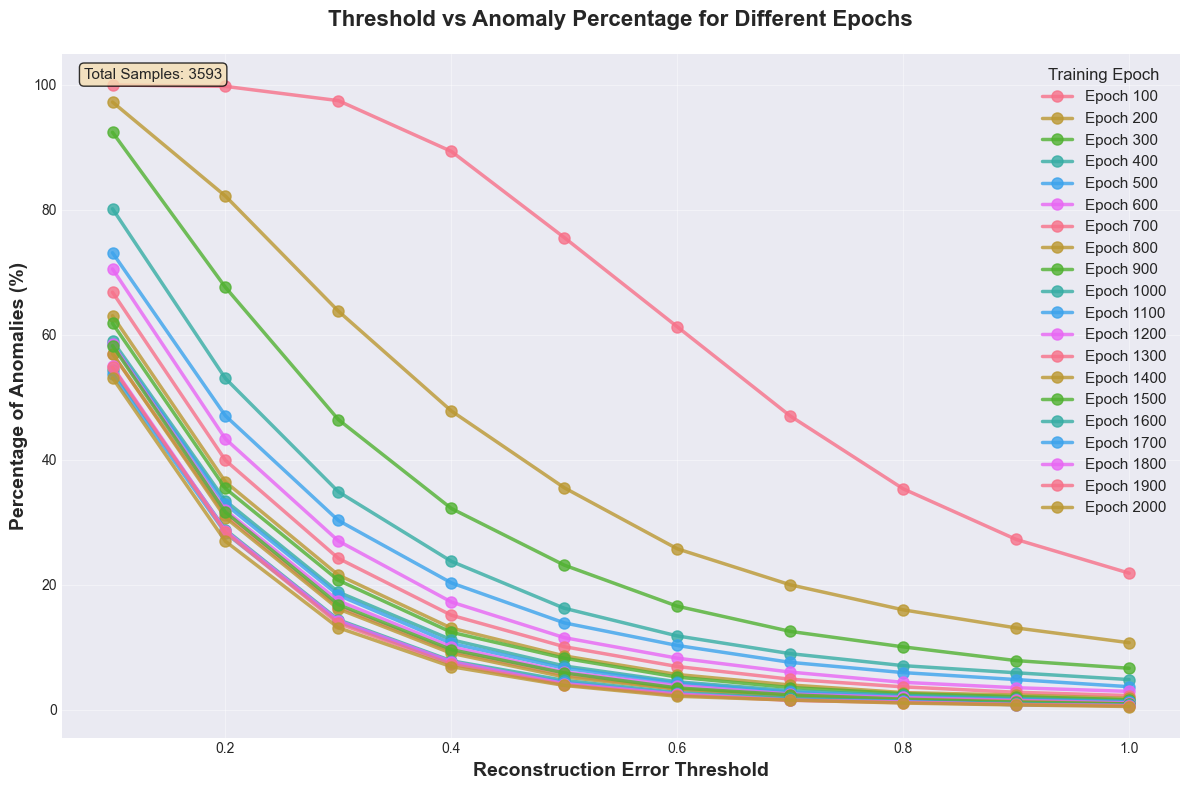

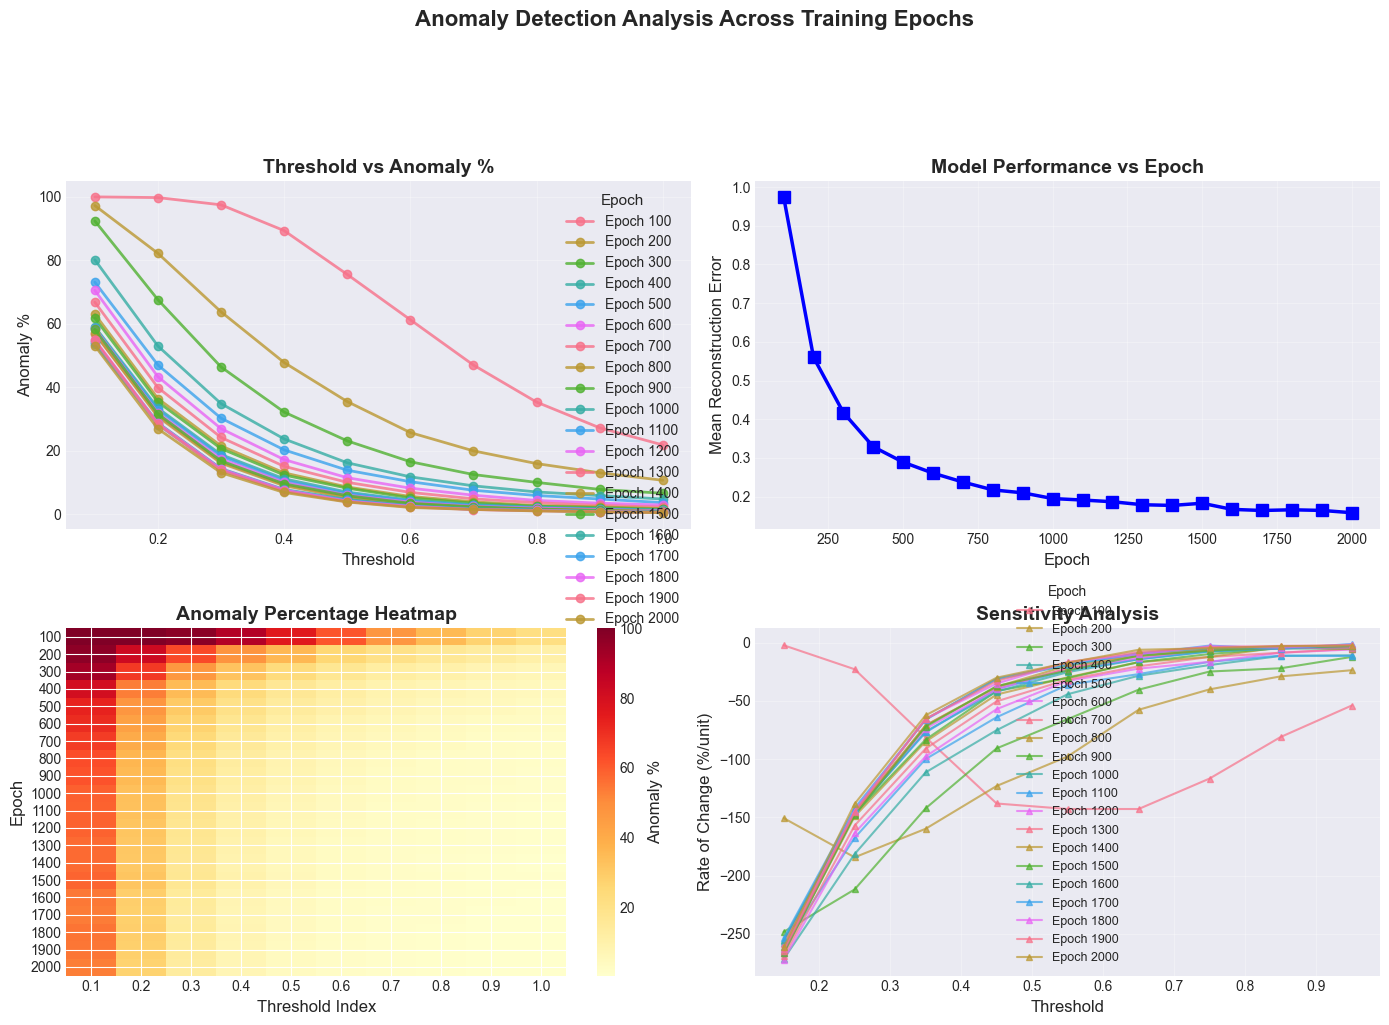


SUMMARY TABLE: Anomaly Percentages by Epoch and Threshold
Epoch     0.1     0.2     0.3     0.4     0.5     0.6     0.7     0.8     0.9     1.0     MeanErr 
--------------------------------------------------------------------------------
100       100.0%   99.8%   97.5%   89.4%   75.6%   61.3%   47.0%   35.3%   27.2%   21.8%  0.9746  
200        97.3%   82.2%   63.8%   47.8%   35.5%   25.7%   20.0%   16.0%   13.1%   10.7%  0.5600  
300        92.4%   67.6%   46.4%   32.2%   23.1%   16.6%   12.5%   10.0%    7.8%    6.6%  0.4171  
400        80.2%   53.0%   34.9%   23.7%   16.2%   11.8%    9.0%    7.0%    5.9%    4.8%  0.3289  
500        73.1%   47.0%   30.3%   20.3%   13.9%   10.3%    7.6%    5.9%    4.8%    3.7%  0.2890  
600        70.6%   43.3%   27.0%   17.2%   11.5%    8.2%    6.0%    4.4%    3.5%    2.9%  0.2607  
700        66.8%   39.9%   24.2%   15.1%   10.1%    6.9%    4.9%    3.6%    2.8%    2.3%  0.2377  
800        63.1%   36.5%   21.5%   13.1%    8.6%    5.6%    4.0%    

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.util import resume_training


# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Prepare data storage
epoch_results = {}
threshold_values = np.arange(0.1, 1.01, 0.1)  # From 0.1 to 1.0 in steps of 0.1
epochs_to_check = range(100, 2001, 100)

# Loop through epochs
for epoch in epochs_to_check:
    print(f"\nProcessing epoch {epoch}...")
    
    # Resume training and get model state
    start_epoch, training_losses, validation_losses = resume_training(
        f'{checkpoint_path}/RNN_VAE_checkpoint_epoch{epoch}.pth', model, optimizer
    )
    
    # Detect anomalies
    results = detect_anomalies_with_weights(model, all_loader, threshold_percentile=95, device=device)
    
    # Calculate percentage of anomalies for each threshold
    percentages = []
    total_samples = len(results['reconstruction_errors'])
    
    for threshold in threshold_values:
        anomaly_indices = np.where(results['reconstruction_errors'] > threshold)[0]
        percentage = len(anomaly_indices) / total_samples * 100
        percentages.append(percentage)
    
    # Store results
    epoch_results[epoch] = {
        'thresholds': threshold_values,
        'percentages': np.array(percentages),
        'total_samples': total_samples,
        'model_error_mean': results['reconstruction_errors'].mean(),
        'model_error_std': results['reconstruction_errors'].std()
    }
    
    print(f"  Epoch {epoch}: Mean reconstruction error = {epoch_results[epoch]['model_error_mean']:.4f}")

# Create overlay plot
plt.figure(figsize=(12, 8))

# Plot each epoch's curve
for epoch in epochs_to_check:
    plt.plot(epoch_results[epoch]['thresholds'], 
             epoch_results[epoch]['percentages'],
             marker='o', 
             linewidth=2.5,
             markersize=8,
             label=f'Epoch {epoch}',
             alpha=0.8)

# Customize plot
plt.xlabel('Reconstruction Error Threshold', fontsize=14, fontweight='bold')
plt.ylabel('Percentage of Anomalies (%)', fontsize=14, fontweight='bold')
plt.title('Threshold vs Anomaly Percentage for Different Epochs', 
          fontsize=16, fontweight='bold', pad=20)
plt.legend(title='Training Epoch', title_fontsize=12, fontsize=11, loc='best')
plt.grid(True, alpha=0.4)

# Add annotation for total samples
total_samples = epoch_results[epochs_to_check[0]]['total_samples']
plt.annotate(f'Total Samples: {total_samples}', 
             xy=(0.02, 0.98), xycoords='axes fraction',
             fontsize=11, ha='left', va='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Create subplot with additional analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Main overlay plot (top-left)
ax1 = axes[0, 0]
for epoch in epochs_to_check:
    ax1.plot(epoch_results[epoch]['thresholds'], 
             epoch_results[epoch]['percentages'],
             marker='o', linewidth=2, markersize=6,
             label=f'Epoch {epoch}', alpha=0.8)
ax1.set_xlabel('Threshold', fontsize=12)
ax1.set_ylabel('Anomaly %', fontsize=12)
ax1.set_title('Threshold vs Anomaly %', fontsize=14, fontweight='bold')
ax1.legend(title='Epoch', fontsize=10, title_fontsize=11)
ax1.grid(True, alpha=0.3)

# 2. Model performance vs epoch (top-right)
ax2 = axes[0, 1]
mean_errors = [epoch_results[epoch]['model_error_mean'] for epoch in epochs_to_check]
ax2.plot(epochs_to_check, mean_errors, 'b-', marker='s', linewidth=2.5, markersize=8)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Mean Reconstruction Error', fontsize=12)
ax2.set_title('Model Performance vs Epoch', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Heatmap of anomaly percentages (bottom-left)
ax3 = axes[1, 0]
# Create matrix for heatmap
heatmap_data = np.array([epoch_results[epoch]['percentages'] for epoch in epochs_to_check])
im = ax3.imshow(heatmap_data, aspect='auto', cmap='YlOrRd')
ax3.set_xlabel('Threshold Index', fontsize=12)
ax3.set_ylabel('Epoch', fontsize=12)
ax3.set_title('Anomaly Percentage Heatmap', fontsize=14, fontweight='bold')
ax3.set_xticks(range(len(threshold_values)))
ax3.set_xticklabels([f'{t:.1f}' for t in threshold_values])
ax3.set_yticks(range(len(epochs_to_check)))
ax3.set_yticklabels([f'{e}' for e in epochs_to_check])

# Add colorbar
cbar = plt.colorbar(im, ax=ax3)
cbar.set_label('Anomaly %', fontsize=12)

# 4. Rate of change (bottom-right)
ax4 = axes[1, 1]
for epoch in epochs_to_check:
    percentages = epoch_results[epoch]['percentages']
    rate_of_change = np.diff(percentages) / np.diff(threshold_values)
    mid_points = (threshold_values[:-1] + threshold_values[1:]) / 2
    ax4.plot(mid_points, rate_of_change, marker='^', linewidth=1.5, 
             markersize=5, label=f'Epoch {epoch}', alpha=0.7)
ax4.set_xlabel('Threshold', fontsize=12)
ax4.set_ylabel('Rate of Change (%/unit)', fontsize=12)
ax4.set_title('Sensitivity Analysis', fontsize=14, fontweight='bold')
ax4.legend(title='Epoch', fontsize=9, title_fontsize=10)
ax4.grid(True, alpha=0.3)

plt.suptitle('Anomaly Detection Analysis Across Training Epochs', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Create summary table
print("\n" + "="*80)
print("SUMMARY TABLE: Anomaly Percentages by Epoch and Threshold")
print("="*80)

# Header
header = "Epoch".ljust(8)
for thresh in threshold_values:
    header += f"  {thresh:.1f}".ljust(8)
header += "  MeanErr".ljust(10)
print(header)
print("-" * 80)

# Data rows
for epoch in epochs_to_check:
    row = f"{epoch}".ljust(8)
    for i, thresh in enumerate(threshold_values):
        pct = epoch_results[epoch]['percentages'][i]
        row += f"  {pct:5.1f}%".ljust(8)
    mean_err = epoch_results[epoch]['model_error_mean']
    row += f"  {mean_err:.4f}".ljust(10)
    print(row)

print("="*80)

# Save data for further analysis
import pickle

analysis_data = {
    'epoch_results': epoch_results,
    'threshold_values': threshold_values,
    'epochs_to_check': list(epochs_to_check)
}

with open('anomaly_threshold_analysis.pkl', 'wb') as f:
    pickle.dump(analysis_data, f)
print(f"\nAnalysis data saved to 'anomaly_threshold_analysis.pkl'")

# Create interactive plot (if using Jupyter)
try:
    from ipywidgets import interact, widgets
    
    @interact(epoch=widgets.Dropdown(
        options=list(epochs_to_check),
        value=list(epochs_to_check)[0],
        description='Epoch:'
    ))
    def plot_interactive(epoch):
        fig, ax = plt.subplots(figsize=(10, 6))
        
        ax.plot(epoch_results[epoch]['thresholds'], 
                epoch_results[epoch]['percentages'],
                'b-', marker='o', linewidth=2.5, markersize=8)
        
        ax.set_xlabel('Reconstruction Error Threshold', fontsize=12)
        ax.set_ylabel('Percentage of Anomalies (%)', fontsize=12)
        ax.set_title(f'Epoch {epoch}: Threshold vs Anomaly Percentage\n'
                    f'Mean Error: {epoch_results[epoch]["model_error_mean"]:.4f}', 
                    fontsize=14)
        ax.grid(True, alpha=0.3)
        
        # Add threshold markers
        for thresh, pct in zip(epoch_results[epoch]['thresholds'], 
                               epoch_results[epoch]['percentages']):
            ax.annotate(f'{pct:.1f}%', 
                       xy=(thresh, pct),
                       xytext=(0, 10),
                       textcoords='offset points',
                       ha='center',
                       fontsize=9,
                       alpha=0.7)
        
        plt.tight_layout()
        plt.show()
    
    print("\nInteractive plot available. Use the dropdown to select different epochs.")
except ImportError:
    print("\nNote: Install ipywidgets for interactive plots: pip install ipywidgets")

### end

In [110]:
# for item in range(len(all_data)):
print([all_data[item].shape[0] for item in range(len(all_data))])
print(max([all_data[item].shape[0] for item in range(len(all_data))]))
print(Counter([all_data[item].shape[0] for item in range(len(all_data))]))

[56, 56, 55, 55, 55, 53, 53, 56, 53, 55, 54, 55, 55, 54, 55, 54, 54, 53, 56, 54, 55, 53, 56, 55, 54, 53, 45, 54, 54, 53, 53, 54, 47, 52, 51, 51, 53, 54, 53, 44, 51, 48, 54, 51, 48, 53, 44, 54, 48, 51, 50, 37, 37, 37, 36, 36, 37, 40, 36, 36, 36, 38, 38, 38, 37, 37, 38, 38, 37, 38, 36, 37, 40, 36, 40, 40, 40, 40, 41, 36, 40, 41, 41, 40, 40, 40, 41, 41, 37, 40, 37, 56, 40, 41, 40, 41, 41, 39, 40, 41, 40, 41, 41, 41, 40, 40, 40, 49, 41, 49, 41, 41, 40, 40, 48, 49, 49, 49, 49, 40, 40, 49, 49, 50, 41, 49, 49, 50, 52, 49, 49, 49, 48, 48, 50, 49, 49, 49, 49, 50, 42, 40, 39, 48, 50, 48, 41, 48, 50, 43, 49, 42, 42, 42, 43, 40, 42, 39, 40, 39, 42, 42, 43, 42, 40, 42, 42, 43, 42, 42, 42, 38, 42, 42, 42, 44, 40, 42, 42, 41, 47, 41, 45, 47, 47, 46, 47, 46, 46, 46, 47, 46, 47, 45, 46, 46, 44, 47, 46, 39, 34, 46, 36, 46, 48, 46, 35, 34, 35, 34, 34, 35, 35, 35, 35, 34, 36, 34, 34, 35, 35, 35, 36, 34, 34, 34, 34, 38, 40, 40, 46, 40, 39, 38, 44, 38, 44, 44, 40, 42, 44, 38, 44, 36, 42, 47, 45, 43, 43, 42,

In [293]:
epochs = 800
start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)

results  = detect_anomalies_with_weights(model, all_loader, threshold_percentile=95, device='cuda')

anomaly_indices = np.where(results['reconstruction_errors'] > 0.5)[0]
anomaly_indices = np.where(results['reconstruction_errors'] < 0.1)[0]
# anomaly_indices = np.where((results['reconstruction_errors'] > 0.3) & (results['reconstruction_errors'] < 0.32))[0]
# anomaly_indices = np.where(~results['anomaly_predictions'])[0]
print(anomaly_indices)
print(len(anomaly_indices))

all_indices = sorted([results['ids'][anomaly_index] for anomaly_index in anomaly_indices])
print(all_indices)

label_names = [all_labels[label_index] for label_index in all_indices]
print(label_names)

<>:2: SyntaxWarning: invalid escape sequence '\R'
<>:2: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_2992\3171253794.py:2: SyntaxWarning: invalid escape sequence '\R'
  start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)


Resumed training from epoch 800
[   1    7    8 ... 3583 3585 3587]
1335
[tensor(1), tensor(9), tensor(10), tensor(11), tensor(18), tensor(20), tensor(22), tensor(23), tensor(25), tensor(27), tensor(29), tensor(30), tensor(31), tensor(38), tensor(39), tensor(48), tensor(49), tensor(51), tensor(54), tensor(56), tensor(57), tensor(58), tensor(60), tensor(62), tensor(64), tensor(65), tensor(67), tensor(68), tensor(71), tensor(73), tensor(74), tensor(75), tensor(82), tensor(84), tensor(85), tensor(86), tensor(87), tensor(90), tensor(92), tensor(93), tensor(94), tensor(97), tensor(99), tensor(100), tensor(103), tensor(104), tensor(105), tensor(107), tensor(109), tensor(111), tensor(113), tensor(114), tensor(115), tensor(117), tensor(118), tensor(119), tensor(121), tensor(124), tensor(127), tensor(132), tensor(136), tensor(137), tensor(138), tensor(139), tensor(140), tensor(141), tensor(142), tensor(144), tensor(145), tensor(146), tensor(151), tensor(152), tensor(153), tensor(160), tensor(16

<>:9: SyntaxWarning: invalid escape sequence '\R'
<>:9: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_2992\1670094384.py:9: SyntaxWarning: invalid escape sequence '\R'
  start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)


Resumed training from epoch 600
Epoch 600 - Padded length: 58
Resumed training from epoch 700
Epoch 700 - Padded length: 58
Resumed training from epoch 800
Epoch 800 - Padded length: 58
Resumed training from epoch 900
Epoch 900 - Padded length: 58
Resumed training from epoch 1000
Epoch 1000 - Padded length: 58
Resumed training from epoch 1100
Epoch 1100 - Padded length: 58
Resumed training from epoch 1200
Epoch 1200 - Padded length: 58
Resumed training from epoch 1300
Epoch 1300 - Padded length: 58
Resumed training from epoch 1400
Epoch 1400 - Padded length: 58


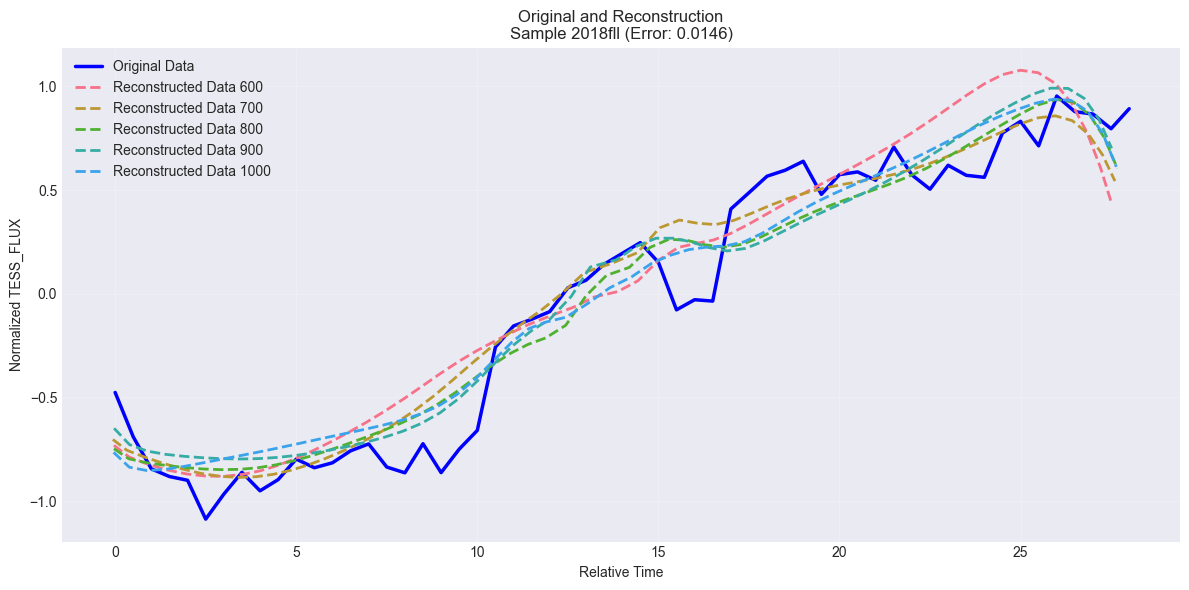

In [295]:
label_name = '2019pkz'
label_name = '2021iff'
label_name = '2018fll'

recon_data_all = {}
orig_data = []

for epochs in range(600, 1401, 100):
    start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)
    results = detect_anomalies_with_weights(model, all_loader, threshold_percentile=95, device=device)

    recon_all_ids = [results['ids'][i].item() for i in range(len(results['ids']))]
    anomaly_index = recon_all_ids.index(all_labels.index(label_name))
    seq_length = results['sequence_lengths'][anomaly_index]  # Get actual length before padding

    print(f"Epoch {epochs} - Padded length: {len(results['original_data'][anomaly_index])}")
    orig_data = results['original_data'][anomaly_index][:seq_length]  # Remove padding
    recon_data = results['reconstructed_data'][anomaly_index][:seq_length]  # Remove padding

    recon_data_all[epochs] = recon_data

# Minimalist clean overlap plot
plt.figure(figsize=(12, 6))

# Plot with minimal styling
plt.plot(orig_data[:, 0], orig_data[:, 1], 'b-', linewidth=2.5, label='Original Data')

for epochs in recon_data_all.keys():
    if epochs > 1000:
        continue;
    recon_data = recon_data_all[epochs]
    plt.plot(recon_data[:, 0], recon_data[:, 1], linewidth=2, linestyle='--', label=f'Reconstructed Data {epochs}')

plt.xlabel('Relative Time')
plt.ylabel('Normalized TESS_FLUX')
plt.title(f'Original and Reconstruction\nSample {label_name} (Error: {results["reconstruction_errors"][anomaly_index]:.4f})')
plt.legend()
plt.grid(True, alpha=0.2)


plt.tight_layout()
plt.show()

<>:7: SyntaxWarning: invalid escape sequence '\R'
<>:7: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_2992\1476939758.py:7: SyntaxWarning: invalid escape sequence '\R'
  start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)


Resumed training from epoch 600
Epoch 600 - Padded length: 58
Resumed training from epoch 700
Epoch 700 - Padded length: 58
Resumed training from epoch 800
Epoch 800 - Padded length: 58
Resumed training from epoch 900
Epoch 900 - Padded length: 58
Resumed training from epoch 1000
Epoch 1000 - Padded length: 58


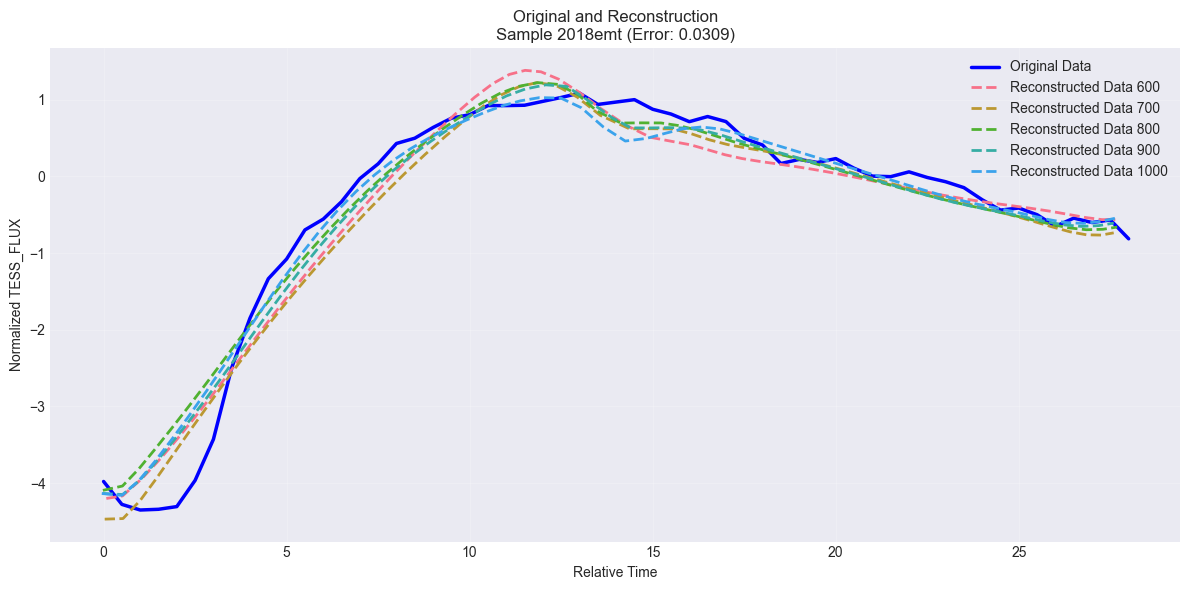

In [297]:
label_name = '2018emt'

recon_data_all = {}
orig_data = []

for epochs in range(600, 1001, 100):
    start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)
    results = detect_anomalies_with_weights(model, all_loader, threshold_percentile=95, device=device)

    recon_all_ids = [results['ids'][i].item() for i in range(len(results['ids']))]
    anomaly_index = recon_all_ids.index(all_labels.index(label_name))
    seq_length = results['sequence_lengths'][anomaly_index]  # Get actual length before padding

    print(f"Epoch {epochs} - Padded length: {len(results['original_data'][anomaly_index])}")
    orig_data = results['original_data'][anomaly_index][:seq_length]  # Remove padding
    recon_data = results['reconstructed_data'][anomaly_index][:seq_length]  # Remove padding

    recon_data_all[epochs] = recon_data

# Minimalist clean overlap plot
plt.figure(figsize=(12, 6))

# Plot with minimal styling
plt.plot(orig_data[:, 0], orig_data[:, 1], 'b-', linewidth=2.5, label='Original Data')

for epochs in recon_data_all.keys():
    if epochs > 1000:
        continue;
    recon_data = recon_data_all[epochs]
    plt.plot(recon_data[:, 0], recon_data[:, 1], linewidth=2, linestyle='--', label=f'Reconstructed Data {epochs}')

plt.xlabel('Relative Time')
plt.ylabel('Normalized TESS_FLUX')
plt.title(f'Original and Reconstruction\nSample {label_name} (Error: {results["reconstruction_errors"][anomaly_index]:.4f})')
plt.legend()
plt.grid(True, alpha=0.2)


plt.tight_layout()
plt.show()

<>:8: SyntaxWarning: invalid escape sequence '\R'
<>:8: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_2992\2380625987.py:8: SyntaxWarning: invalid escape sequence '\R'
  start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)


Resumed training from epoch 100
Epoch 100 - Padded length: 58
Resumed training from epoch 200
Epoch 200 - Padded length: 58
Resumed training from epoch 300
Epoch 300 - Padded length: 58
Resumed training from epoch 400
Epoch 400 - Padded length: 58
Resumed training from epoch 500
Epoch 500 - Padded length: 58
Resumed training from epoch 600
Epoch 600 - Padded length: 58
Resumed training from epoch 700
Epoch 700 - Padded length: 58
Resumed training from epoch 800
Epoch 800 - Padded length: 58
Resumed training from epoch 900
Epoch 900 - Padded length: 58
Resumed training from epoch 1000
Epoch 1000 - Padded length: 58
Resumed training from epoch 1100
Epoch 1100 - Padded length: 58
Resumed training from epoch 1200
Epoch 1200 - Padded length: 58
Resumed training from epoch 1300
Epoch 1300 - Padded length: 58
Resumed training from epoch 1400
Epoch 1400 - Padded length: 58
Resumed training from epoch 1500
Epoch 1500 - Padded length: 58
Resumed training from epoch 1600
Epoch 1600 - Padded lengt

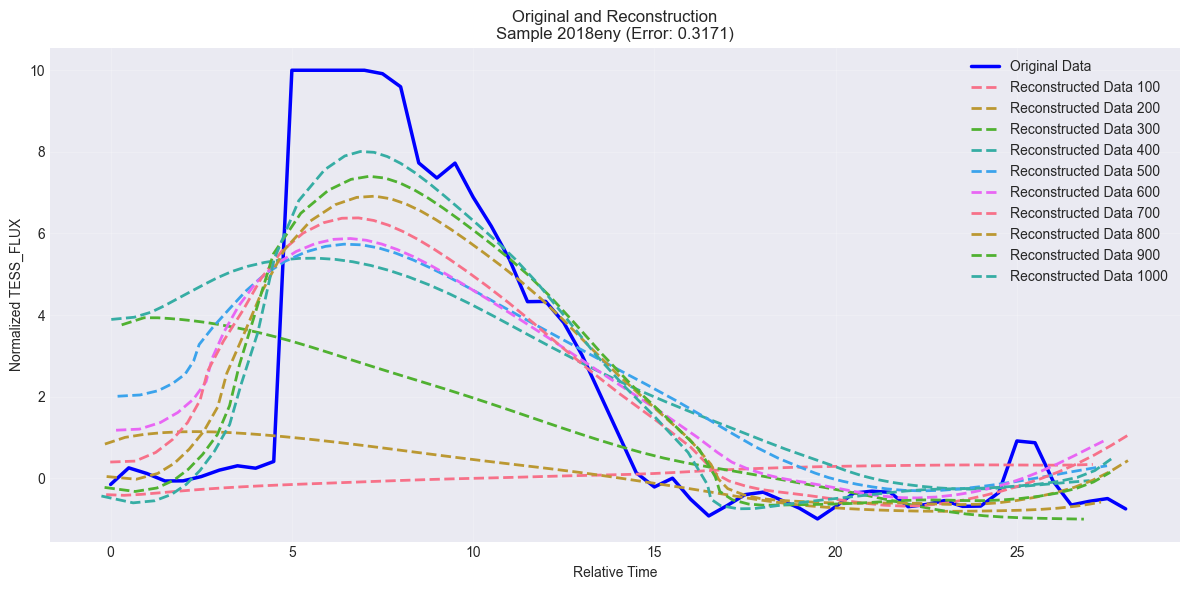

In [298]:
label_name = '2018hql'
label_name = '2018eny'

recon_data_all = {}
orig_data = []

for epochs in range(100, 2001, 100):
    start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)
    results = detect_anomalies_with_weights(model, all_loader, threshold_percentile=95, device=device)

    recon_all_ids = [results['ids'][i].item() for i in range(len(results['ids']))]
    anomaly_index = recon_all_ids.index(all_labels.index(label_name))
    seq_length = results['sequence_lengths'][anomaly_index]  # Get actual length before padding

    print(f"Epoch {epochs} - Padded length: {len(results['original_data'][anomaly_index])}")
    orig_data = results['original_data'][anomaly_index][:seq_length]  # Remove padding
    recon_data = results['reconstructed_data'][anomaly_index][:seq_length]  # Remove padding

    recon_data_all[epochs] = recon_data

# Minimalist clean overlap plot
plt.figure(figsize=(12, 6))

# Plot with minimal styling
plt.plot(orig_data[:, 0], orig_data[:, 1], 'b-', linewidth=2.5, label='Original Data')

for epochs in recon_data_all.keys():
    if epochs > 1000:
        continue;
    recon_data = recon_data_all[epochs]
    plt.plot(recon_data[:, 0], recon_data[:, 1], linewidth=2, linestyle='--', label=f'Reconstructed Data {epochs}')

plt.xlabel('Relative Time')
plt.ylabel('Normalized TESS_FLUX')
plt.title(f'Original and Reconstruction\nSample {label_name} (Error: {results["reconstruction_errors"][anomaly_index]:.4f})')
plt.legend()
plt.grid(True, alpha=0.2)


plt.tight_layout()
plt.show()

<>:7: SyntaxWarning: invalid escape sequence '\R'
<>:7: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_2992\694530293.py:7: SyntaxWarning: invalid escape sequence '\R'
  start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)


Resumed training from epoch 100
Epoch 100 - Padded length: 58
Resumed training from epoch 200
Epoch 200 - Padded length: 58
Resumed training from epoch 300
Epoch 300 - Padded length: 58
Resumed training from epoch 400
Epoch 400 - Padded length: 58
Resumed training from epoch 500
Epoch 500 - Padded length: 58
Resumed training from epoch 600
Epoch 600 - Padded length: 58
Resumed training from epoch 700
Epoch 700 - Padded length: 58
Resumed training from epoch 800
Epoch 800 - Padded length: 58
Resumed training from epoch 900
Epoch 900 - Padded length: 58
Resumed training from epoch 1000
Epoch 1000 - Padded length: 58
Resumed training from epoch 1100
Epoch 1100 - Padded length: 58
Resumed training from epoch 1200
Epoch 1200 - Padded length: 58
Resumed training from epoch 1300
Epoch 1300 - Padded length: 58
Resumed training from epoch 1400
Epoch 1400 - Padded length: 58
Resumed training from epoch 1500
Epoch 1500 - Padded length: 58
Resumed training from epoch 1600
Epoch 1600 - Padded lengt

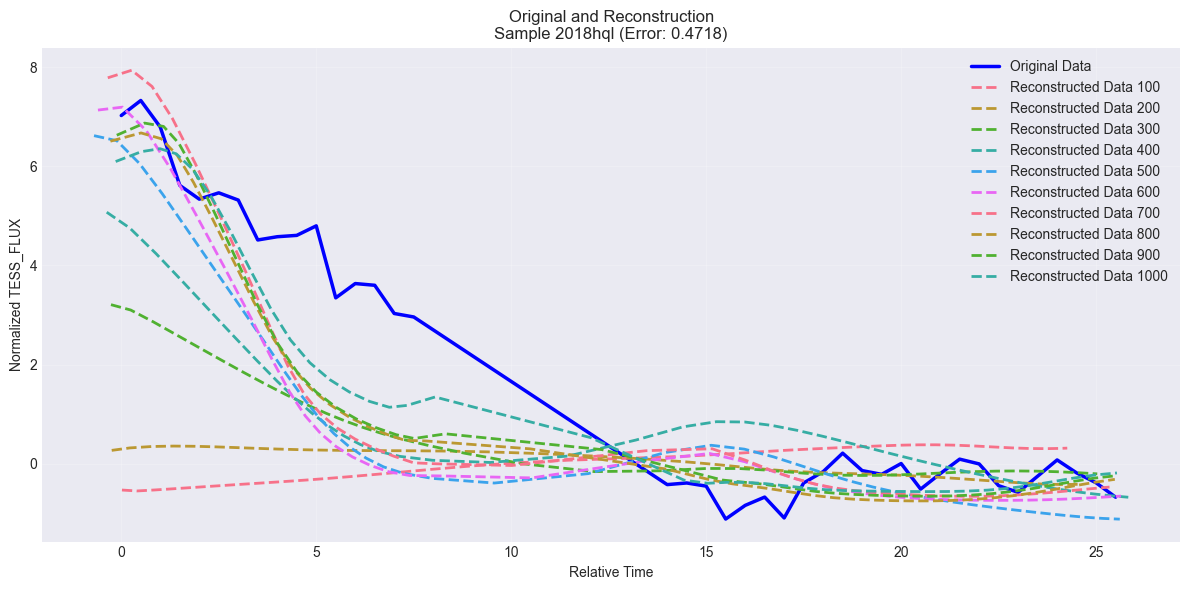

In [299]:
label_name = '2018hql'

recon_data_all = {}
orig_data = []

for epochs in range(100, 2001, 100):
    start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)
    results = detect_anomalies_with_weights(model, all_loader, threshold_percentile=95, device=device)

    recon_all_ids = [results['ids'][i].item() for i in range(len(results['ids']))]
    anomaly_index = recon_all_ids.index(all_labels.index(label_name))
    seq_length = results['sequence_lengths'][anomaly_index]  # Get actual length before padding

    print(f"Epoch {epochs} - Padded length: {len(results['original_data'][anomaly_index])}")
    orig_data = results['original_data'][anomaly_index][:seq_length]  # Remove padding
    recon_data = results['reconstructed_data'][anomaly_index][:seq_length]  # Remove padding

    recon_data_all[epochs] = recon_data# Minimalist clean overlap plot
    
plt.figure(figsize=(12, 6))

# Plot with minimal styling
plt.plot(orig_data[:, 0], orig_data[:, 1], 'b-', linewidth=2.5, label='Original Data')

for epochs in recon_data_all.keys():
    if epochs > 1000:
        continue;
    recon_data = recon_data_all[epochs]
    plt.plot(recon_data[:, 0], recon_data[:, 1], linewidth=2, linestyle='--', label=f'Reconstructed Data {epochs}')

plt.xlabel('Relative Time')
plt.ylabel('Normalized TESS_FLUX')
plt.title(f'Original and Reconstruction\nSample {label_name} (Error: {results["reconstruction_errors"][anomaly_index]:.4f})')
plt.legend()
plt.grid(True, alpha=0.2)


plt.tight_layout()
plt.show()


<>:7: SyntaxWarning: invalid escape sequence '\R'
<>:7: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_2992\2924479693.py:7: SyntaxWarning: invalid escape sequence '\R'
  start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)


Resumed training from epoch 100
Epoch 100 - Padded length: 58
Resumed training from epoch 200
Epoch 200 - Padded length: 58
Resumed training from epoch 300
Epoch 300 - Padded length: 58
Resumed training from epoch 400
Epoch 400 - Padded length: 58
Resumed training from epoch 500
Epoch 500 - Padded length: 58
Resumed training from epoch 600
Epoch 600 - Padded length: 58
Resumed training from epoch 700
Epoch 700 - Padded length: 58
Resumed training from epoch 800
Epoch 800 - Padded length: 58
Resumed training from epoch 900
Epoch 900 - Padded length: 58
Resumed training from epoch 1000
Epoch 1000 - Padded length: 58
Resumed training from epoch 1100
Epoch 1100 - Padded length: 58
Resumed training from epoch 1200
Epoch 1200 - Padded length: 58
Resumed training from epoch 1300
Epoch 1300 - Padded length: 58
Resumed training from epoch 1400
Epoch 1400 - Padded length: 58
Resumed training from epoch 1500
Epoch 1500 - Padded length: 58
Resumed training from epoch 1600
Epoch 1600 - Padded lengt

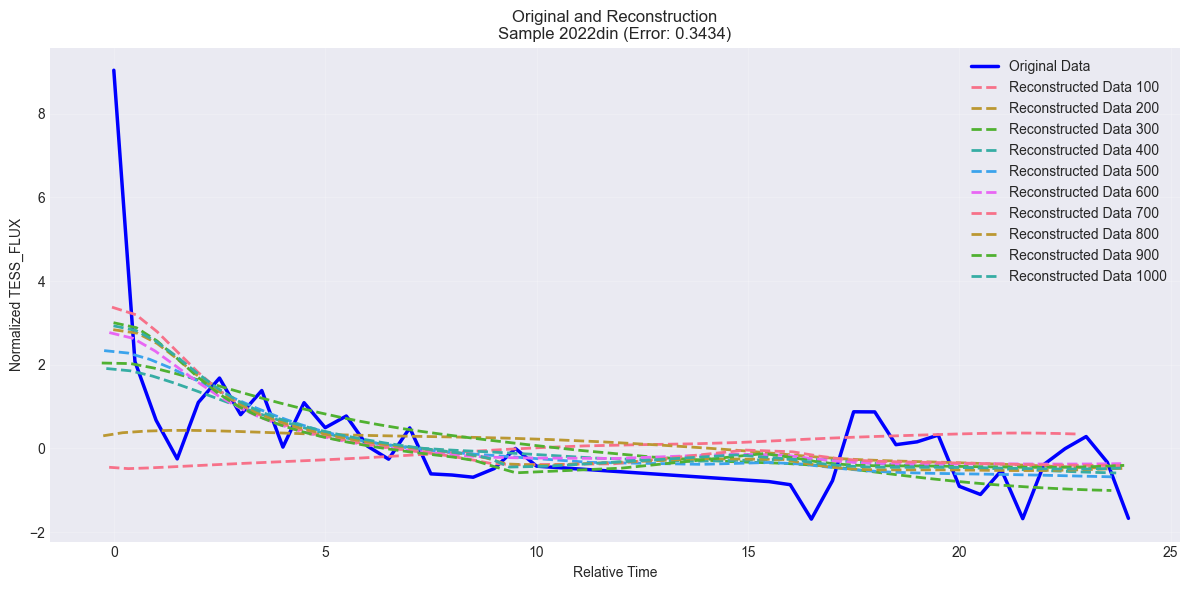

In [300]:
label_name = '2022din'

recon_data_all = {}
orig_data = []

for epochs in range(100, 2001, 100):
    start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)
    results = detect_anomalies_with_weights(model, all_loader, threshold_percentile=95, device=device)

    recon_all_ids = [results['ids'][i].item() for i in range(len(results['ids']))]
    anomaly_index = recon_all_ids.index(all_labels.index(label_name))
    seq_length = results['sequence_lengths'][anomaly_index]  # Get actual length before padding

    print(f"Epoch {epochs} - Padded length: {len(results['original_data'][anomaly_index])}")
    orig_data = results['original_data'][anomaly_index][:seq_length]  # Remove padding
    recon_data = results['reconstructed_data'][anomaly_index][:seq_length]  # Remove padding

    recon_data_all[epochs] = recon_data# Minimalist clean overlap plot
    
plt.figure(figsize=(12, 6))

# Plot with minimal styling
plt.plot(orig_data[:, 0], orig_data[:, 1], 'b-', linewidth=2.5, label='Original Data')

for epochs in recon_data_all.keys():
    if epochs > 1000:
        continue;
    recon_data = recon_data_all[epochs]
    plt.plot(recon_data[:, 0], recon_data[:, 1], linewidth=2, linestyle='--', label=f'Reconstructed Data {epochs}')

plt.xlabel('Relative Time')
plt.ylabel('Normalized TESS_FLUX')
plt.title(f'Original and Reconstruction\nSample {label_name} (Error: {results["reconstruction_errors"][anomaly_index]:.4f})')
plt.legend()
plt.grid(True, alpha=0.2)


plt.tight_layout()
plt.show()


In [308]:
epochs = 700
start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)

results  = detect_anomalies_with_weights(model, all_loader, threshold_percentile=95, device='cuda')

anomaly_indices = np.where(results['reconstruction_errors'] > 0.5)[0]
# print(anomaly_indices)
print(len(anomaly_indices))

all_indices = sorted([results['ids'][anomaly_index].tolist() for anomaly_index in anomaly_indices])
print(all_indices)

label_names = [all_labels[label_index] for label_index in all_indices]
print(label_names)

label_names_800 = label_names

Resumed training from epoch 700
363
[2, 13, 17, 34, 36, 44, 50, 52, 80, 81, 91, 112, 116, 128, 134, 135, 147, 149, 154, 159, 165, 197, 212, 216, 243, 246, 252, 253, 259, 269, 270, 279, 294, 298, 300, 304, 310, 312, 314, 317, 326, 328, 343, 349, 411, 427, 433, 445, 454, 469, 470, 484, 513, 521, 526, 527, 534, 543, 566, 581, 601, 622, 623, 634, 643, 649, 650, 658, 661, 662, 667, 669, 680, 685, 687, 688, 697, 705, 712, 714, 718, 723, 724, 729, 735, 769, 771, 773, 790, 801, 818, 854, 877, 880, 881, 917, 921, 923, 940, 948, 968, 980, 986, 999, 1014, 1017, 1022, 1026, 1027, 1034, 1043, 1047, 1058, 1059, 1060, 1061, 1063, 1074, 1075, 1077, 1085, 1087, 1097, 1113, 1116, 1124, 1126, 1144, 1149, 1158, 1186, 1221, 1244, 1275, 1286, 1292, 1302, 1303, 1306, 1323, 1331, 1334, 1357, 1365, 1383, 1397, 1423, 1443, 1459, 1467, 1507, 1526, 1542, 1543, 1544, 1549, 1566, 1582, 1615, 1631, 1644, 1670, 1675, 1682, 1731, 1737, 1745, 1748, 1757, 1759, 1760, 1761, 1767, 1768, 1769, 1773, 1781, 1790, 1795, 1796,

In [23]:
epochs = 800
start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)

results  = detect_anomalies_with_weights(model, all_loader, threshold_percentile=95, device='cuda')

anomaly_indices = np.where(results['reconstruction_errors'] > 0.5)[0]
# print(anomaly_indices)
print(len(anomaly_indices))

all_indices = sorted([results['ids'][anomaly_index].tolist() for anomaly_index in anomaly_indices])
print(all_indices)

label_names = [all_labels[label_index] for label_index in all_indices]
print(label_names)

label_names_800 = label_names

Resumed training from epoch 800
310
[2, 13, 17, 34, 44, 52, 80, 81, 91, 112, 116, 128, 134, 135, 147, 149, 154, 159, 165, 197, 212, 234, 243, 246, 252, 253, 259, 269, 270, 294, 298, 300, 304, 314, 317, 328, 343, 349, 411, 433, 454, 469, 470, 513, 526, 527, 581, 601, 622, 623, 643, 649, 650, 662, 667, 669, 680, 685, 687, 688, 705, 712, 714, 718, 723, 724, 729, 735, 769, 771, 790, 801, 818, 854, 868, 877, 880, 881, 917, 921, 922, 923, 924, 940, 948, 980, 986, 999, 1014, 1022, 1026, 1034, 1043, 1058, 1059, 1061, 1063, 1074, 1075, 1085, 1087, 1097, 1113, 1116, 1126, 1144, 1149, 1186, 1221, 1244, 1275, 1286, 1292, 1302, 1303, 1306, 1323, 1331, 1334, 1365, 1383, 1397, 1423, 1443, 1459, 1507, 1543, 1544, 1549, 1566, 1582, 1615, 1631, 1675, 1682, 1731, 1745, 1748, 1759, 1760, 1761, 1767, 1768, 1769, 1773, 1781, 1790, 1795, 1796, 1797, 1818, 1822, 1849, 1897, 1898, 1921, 1932, 1933, 1946, 1958, 1964, 1968, 1970, 1992, 1996, 1999, 2018, 2026, 2085, 2117, 2125, 2127, 2144, 2161, 2177, 2215, 2228,

In [ ]:
# set_all = set.intersection(*(set(lst) for lst in [label_names_800, label_names_700]))
# set_all = set.intersection(*(set(lst) for lst in [m3, label_names_700]))
set_all = set.intersection(*(set(lst) for lst in [list2, list3, all_indices]))
# set_all = set.intersection(*(set(lst) for lst in [list2, list3]))


print(len(set_all))
print(sorted(set_all))
# 70
# [2, 17, 36, 52, 80, 116, 134, 135, 149, 159, 197, 216, 252, 259, 298, 300, 314, 326, 328, 343, 349, 411, 427, 445, 484, 521, 601, 623, 667, 688, 735, 818, 881, 968, 1077, 1085, 1244, 1306, 1357, 1526, 1542, 1731, 1932, 2215, 2228, 2280, 2311, 2312, 2345, 2355, 2382, 2447, 2530, 2585, 2665, 2714, 2846, 2851, 2881, 2892, 2914, 2976, 3019, 3046, 3065, 3135, 3256, 3319, 3358, 3421]

In [282]:
epochs = 800
start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)

Resumed training from epoch 800


<>:2: SyntaxWarning: invalid escape sequence '\R'
<>:2: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_2992\3810606844.py:2: SyntaxWarning: invalid escape sequence '\R'
  start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)


In [283]:
results  = detect_anomalies_with_weights(model, all_loader, threshold_percentile=95, device='cuda')

# print(results)
results.keys()

dict_keys(['ids', 'reconstruction_errors', 'anomaly_predictions', 'threshold', 'labels', 'original_data', 'reconstructed_data', 'sequence_lengths', 'weights', 'threshold_percentile'])

In [266]:
label_name = '2018hql'
origin_index = all_labels.index(label_name)

print(f'label_name: {label_name} for origin_index: {origin_index}')

recon_all_ids = [results['ids'][i].item() for i in range(len(results['ids']))]
print(f'recon_all_ids: {recon_all_ids}')

recon_index = recon_all_ids.index(all_labels.index(label_name))
print(f'recon_index: {recon_index}')
# recon_index = 2902
all_labels[results['ids'][recon_index].item()]

# all_labels.index('2021xpo')
# all_labels[2902]
# all_ids[2902]
# # all_indices.index(2902) 
# # 2021xpo 2902

label_name: 2018hql for origin_index: 80
recon_all_ids: [376, 1714, 2120, 993, 2556, 1957, 770, 1803, 779, 2512, 3140, 1510, 1565, 1384, 1800, 1093, 2973, 2274, 267, 1903, 3516, 183, 2116, 3078, 2318, 2109, 3375, 2823, 3460, 1948, 2042, 3235, 2328, 1139, 1068, 3134, 3385, 1276, 1199, 2565, 963, 891, 2834, 488, 2991, 533, 2405, 900, 1214, 3244, 2747, 1705, 2221, 1196, 2969, 2329, 1639, 1985, 1652, 2914, 3153, 357, 829, 2880, 2566, 2286, 2204, 22, 1936, 1349, 17, 2061, 1908, 1301, 614, 734, 1818, 2776, 1094, 2955, 2530, 930, 534, 2165, 283, 1967, 2400, 2103, 3028, 3360, 292, 2983, 439, 469, 527, 2984, 765, 2002, 1581, 26, 321, 2727, 1618, 713, 53, 1598, 2251, 1952, 2037, 845, 1669, 1274, 955, 1173, 1941, 1926, 2, 1475, 2447, 939, 2499, 3573, 621, 1342, 2647, 3007, 103, 1334, 2685, 968, 3094, 140, 1683, 3020, 717, 424, 2884, 858, 3566, 2615, 1678, 83, 889, 2753, 3421, 130, 73, 2459, 124, 1209, 147, 1640, 519, 2223, 202, 2852, 1099, 280, 3465, 1589, 2261, 1304, 322, 775, 3441, 1842, 3145, 

'2018hql'

Actual sequence length: 40
Padded length: 58


C:\Users\xuesh\AppData\Local\Temp\ipykernel_2992\773703027.py:22: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(recon_data[:, 0], recon_data[:, 1], 'g-', linewidth=2, linestyle='--', label=f'Reconstructed Data {epochs}')


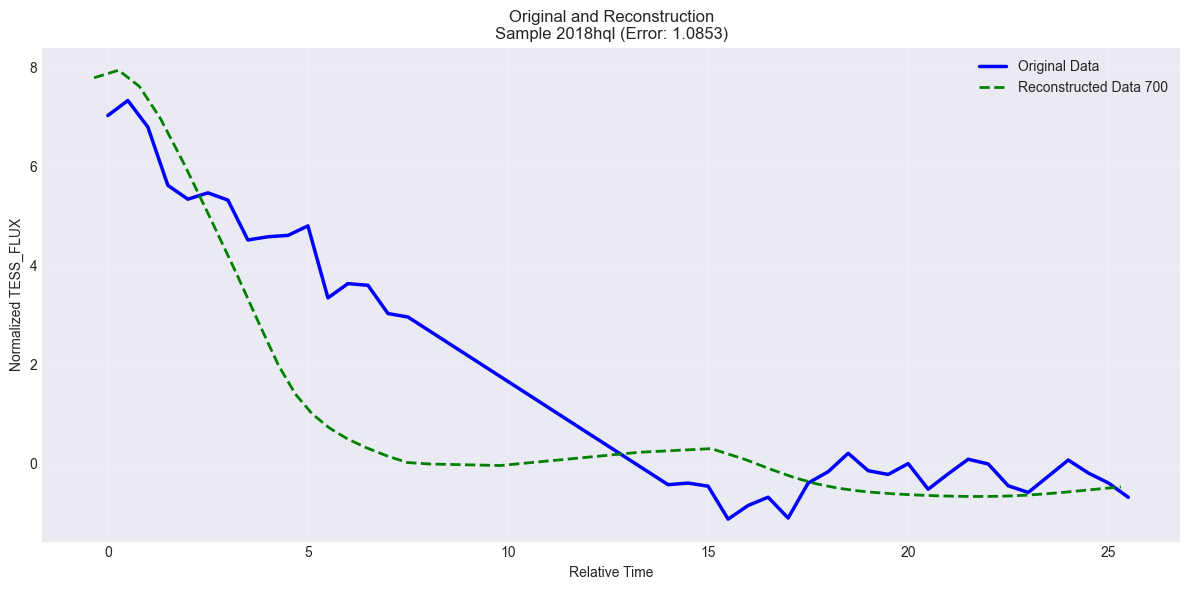

In [273]:
label_name = '2018hql'
recon_all_ids = [results['ids'][i].item() for i in range(len(results['ids']))]

anomaly_index = recon_all_ids.index(all_labels.index(label_name))

seq_length = results['sequence_lengths'][anomaly_index]  # Get actual length before padding

print(f"Actual sequence length: {seq_length}")
print(f"Padded length: {len(results['original_data'][anomaly_index])}")
orig_data = results['original_data'][anomaly_index][:seq_length]  # Remove padding
recon_data = results['reconstructed_data'][anomaly_index][:seq_length]  # Remove padding

# print(f"Original Data Shape: {orig_data}")
# print(f"Reconstructed Data Shape: {recon_data}")


# Minimalist clean overlap plot
plt.figure(figsize=(12, 6))

# Plot with minimal styling
plt.plot(orig_data[:, 0], orig_data[:, 1], 'b-', linewidth=2.5, label='Original Data')
plt.plot(recon_data[:, 0], recon_data[:, 1], 'g-', linewidth=2, linestyle='--', label=f'Reconstructed Data {epochs}')

plt.xlabel('Relative Time')
plt.ylabel('Normalized TESS_FLUX')
plt.title(f'Original and Reconstruction\nSample {label_name} (Error: {results["reconstruction_errors"][anomaly_index]:.4f})')
plt.legend()
plt.grid(True, alpha=0.2)


plt.tight_layout()
plt.show()


# Isolation Forest Sensitivity 

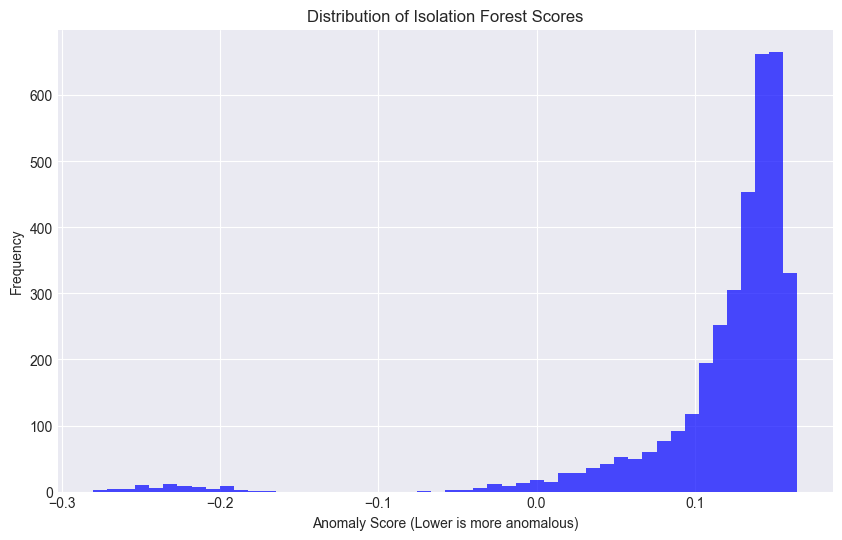

Data-driven contamination based on IQR: 0.0871


In [26]:
def if_score_distribution(X):
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.ensemble import IsolationForest

    # 1. Fit the model
    clf = IsolationForest(contamination='auto', random_state=42)
    clf.fit(X)

    # 2. Get anomaly scores (Lower = more abnormal)
    scores = clf.decision_function(X)

    # 3. Visualization: Plot histogram to find the "Elbow"
    plt.figure(figsize=(10, 6))
    plt.hist(scores, bins=50, alpha=0.7, color='blue')
    plt.title("Distribution of Isolation Forest Scores")
    plt.xlabel("Anomaly Score (Lower is more anomalous)")
    plt.ylabel("Frequency")
    # plt.axvline(x=-0.2, color='r', linestyle='--', label='Potential Threshold') # Example threshold
    plt.legend()
    plt.show()

    # 4. Statistical selection (e.g., 3 standard deviations or IQR)
    # This calculates what % of data lies beyond a statistical extreme
    q1 = np.percentile(scores, 25)
    q3 = np.percentile(scores, 75)
    iqr = q3 - q1
    threshold = q1 - 1.5 * iqr # Outlier threshold for the scores

    # Calculate the resulting contamination based on this threshold
    implied_contamination = (scores < threshold).mean()
    print(f"Data-driven contamination based on IQR: {implied_contamination:.4f}")

    return implied_contamination

STATISTICAL_CONTAMINATION = if_score_distribution(X)

"Following the reviewer's suggestion, we moved away from arbitrary thresholds and adopted a data-driven approach. We analyzed the distribution of anomaly scores generated by the Isolation Forest on the VAE latent space.By applying the Interquartile Range (IQR) rule (defined as $Q_1 - 1.5 \times IQR$) to the decision function scores, we identified the statistical tail of the distribution. This method yielded an intrinsic contamination parameter of 0.0675. This indicates that approximately 6.75% of the samples exhibit statistically significant deviation from the core latent distribution."

In [20]:
STATISTICAL_CONTAMINATION # =0.1

np.float64(0.07319788477595324)

Data shape (Simulated VAE Latent Vectors): (3593, 16)


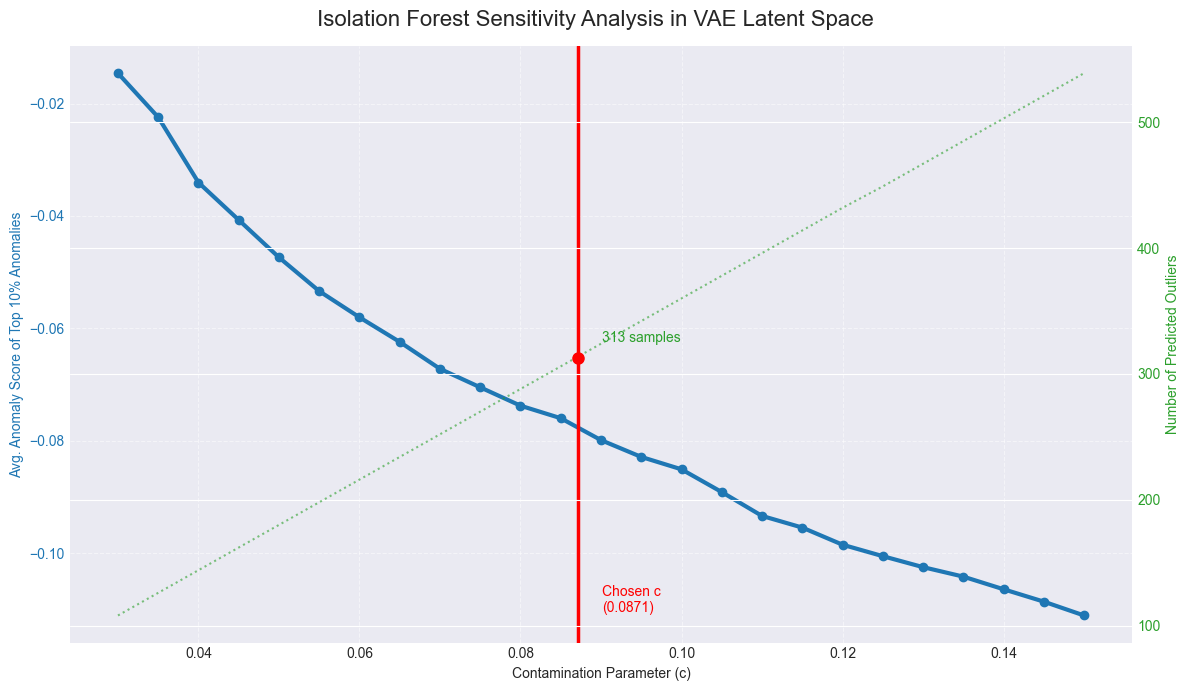

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.datasets import make_blobs

# ==========================================
# CONFIGURATION
# ==========================================
# The contamination parameter derived from your data (IQR method)
# STATISTICAL_CONTAMINATION = 0.1239

# Define the range for the sensitivity analysis plot
# We test from 3% to 15% contamination, centering on 6.75%
CONTAMINATION_RANGE = np.linspace(0.03, 0.15, 25)

# ==========================================
# 1. SETUP: Simulate VAE Latent Vectors
# Replace this section with your actual VAE latent vectors (mu)
# ==========================================
np.random.seed(42)
LATENT_DIM = 16
N_SAMPLES = len(X)

# Simulate a tight cluster of 'normal' VAE latent vectors
# X = np.random.normal(loc=0, scale=1, size=(N_SAMPLES, LATENT_DIM))

# Introduce some true outliers (2% of the data) far from the center
n_outliers = int(N_SAMPLES * 0.02)
outliers = np.random.uniform(low=-8, high=8, size=(n_outliers, LATENT_DIM))
X[:n_outliers] = outliers # Inject them into the dataset

print(f"Data shape (Simulated VAE Latent Vectors): {X.shape}")

# ==========================================
# 2. PERFORM SENSITIVITY ANALYSIS
# ==========================================
# This metric tracks the average intensity of the anomaly signal 
# for a fixed number of the most extreme points, showing signal stability.
avg_top_score_list = []

# Metric 2: The number of points classified as outliers (should be linear)
n_outliers_list = []

# Use a fixed percentage (e.g., top 10%) to measure the signal strength.
TOP_K_PERCENT = 0.10 
top_k = int(N_SAMPLES * TOP_K_PERCENT)

for c in CONTAMINATION_RANGE:
    # 1. Fit the Isolation Forest model
    clf = IsolationForest(contamination=c, random_state=42, n_jobs=-1)
    clf.fit(X)
    
    # 2. Get the anomaly scores (lower score = more anomalous)
    scores = clf.decision_function(X)
    
    # 3. Sort the scores and take the 'Top K' most anomalous scores
    # We sort ascending (lower scores first) and take the first 'top_k' elements
    sorted_scores = np.sort(scores)
    top_k_scores = sorted_scores[:top_k]
    
    # 4. Calculate the average score of these extreme points
    avg_top_score_list.append(np.mean(top_k_scores))

    # 5. Track the number of predicted outliers (should equal c * N_SAMPLES)
    n_outliers_list.append((clf.predict(X) == -1).sum())

# ==========================================
# 3. GENERATE VISUALIZATION
# ==========================================
fig, ax1 = plt.subplots(figsize=(12, 7))
fig.suptitle("Isolation Forest Sensitivity Analysis in VAE Latent Space", fontsize=16)

# --- AXIS 1: Average Anomaly Score (Primary Metric for Robustness) ---
color_score = 'tab:blue'
ax1.set_xlabel('Contamination Parameter (c)')
ax1.set_ylabel(f'Avg. Anomaly Score of Top {TOP_K_PERCENT*100:.0f}% Anomalies', color=color_score)
ax1.plot(CONTAMINATION_RANGE, avg_top_score_list, color=color_score, linewidth=3, marker='o', markersize=6, label='Avg Top K Score')
ax1.tick_params(axis='y', labelcolor=color_score)
ax1.grid(True, linestyle='--', alpha=0.5)

# Highlight the statistically chosen contamination value
ax1.axvline(
    x=STATISTICAL_CONTAMINATION, 
    color='red', 
    linestyle='-', 
    linewidth=2.5, 
    label=f'Data-Driven c = {STATISTICAL_CONTAMINATION:.4f}'
)
# Add a text annotation for the chosen value
ax1.text(
    STATISTICAL_CONTAMINATION + 0.003, 
    min(avg_top_score_list), 
    f'Chosen c\n({STATISTICAL_CONTAMINATION:.4f})', 
    color='red', 
    fontsize=10, 
    verticalalignment='bottom'
)

# --- AXIS 2: Number of Predicted Outliers (Secondary Metric for Context) ---
ax2 = ax1.twinx()  
color_count = 'tab:green'
ax2.set_ylabel('Number of Predicted Outliers', color=color_count)  
ax2.plot(CONTAMINATION_RANGE, n_outliers_list, color=color_count, linestyle=':', alpha=0.6, label='Predicted Outlier Count')
ax2.tick_params(axis='y', labelcolor=color_count)

# Show the predicted count at the chosen contamination level
chosen_count = int(STATISTICAL_CONTAMINATION * N_SAMPLES)
ax2.plot(STATISTICAL_CONTAMINATION, chosen_count, 'ro', markersize=8)
ax2.text(
    STATISTICAL_CONTAMINATION + 0.003, 
    chosen_count + 10, 
    f'{chosen_count} samples', 
    color='tab:green', 
    fontsize=10, 
    verticalalignment='bottom'
)

# Finalize the plot
fig.tight_layout()  # Adjusts plot to prevent labels from overlapping
plt.show()

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Create and fit the Isolation Forest model
# clf = IsolationForest(contamination=0.1)
clf = IsolationForest(contamination=STATISTICAL_CONTAMINATION, n_estimators=1000, random_state=42)
clf.fit(X)

# Predict anomalies
y_pred = clf.predict(X)

indices_raw = np.where(y_pred == -1 )
indices = np.array(latent_label[indices_raw])
indices = indices.flatten()
print(len(indices))
print(sorted(indices))
print([int(i) for i in sorted(indices)])
list3 = [int(i) for i in sorted(indices)]

#  - 100
# [52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 110, 111, 112, 113, 119, 120, 124, 140, 141, 142, 146, 149, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 181, 200, 207, 209, 210, 211, 215, 217, 218, 221, 223, 224, 225, 226, 243, 247, 257, 296, 297, 298, 300, 304, 307, 308, 309, 313, 314, 344, 345, 352, 357, 361, 362, 367, 373, 477, 488, 591, 594, 597, 611, 615, 616, 618, 619, 627, 628, 630, 631, 633, 639, 648, 651, 656, 657, 663, 665, 768, 799, 965, 980, 991, 996, 1003, 1007, 1048, 1051, 1052, 1066, 1072, 1075, 1146, 1164, 1196, 1226, 1227, 1234, 1244, 1255, 1268, 1270, 1284, 1318, 1326, 1327, 1440, 1443, 1445, 1455, 1464, 1470, 1477, 1497, 1498, 1500, 1501, 1505, 1506, 1508, 1510, 1512, 1513, 1514, 1515, 1518, 1522, 1525, 1527, 1578, 1584, 1599, 1602, 1623, 1655, 1671, 1674, 1679, 1701, 1721, 1726, 1748, 1817, 1920, 1927, 1938, 1939, 1940, 1943, 1951, 1956, 1961, 1980, 1993, 2014, 2193, 2412, 2587, 2620, 2622, 2665, 2829, 2840, 2848, 2876, 2896, 2914, 2926, 2970, 2983, 2987, 3020, 3035, 3038, 3072, 3076, 3077, 3169, 3175, 3176, 3180, 3189, 3194, 3196, 3198, 3201, 3204, 3206, 3210, 3215, 3228, 3239, 3240, 3245, 3248, 3251, 3259, 3273, 3282, 3284, 3313, 3374, 3375, 3376, 3401, 3409, 3427, 3432, 3437, 3440, 3442, 3445, 3446, 3459, 3463, 3467, 3479, 3488, 3496, 3498, 3499, 3503, 3506, 3509, 3513, 3527, 3528, 3530, 3532, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3543, 3544, 3545, 3548, 3551, 3552, 3553, 3554, 3557, 3558, 3559, 3560, 3563, 3566, 3568, 3569]
# - 300
# [1, 2, 6, 10, 11, 14, 17, 19, 27, 33, 36, 52, 53, 57, 60, 62, 63, 66, 67, 68, 70, 71, 72, 79, 80, 82, 87, 116, 125, 129, 130, 134, 135, 148, 149, 153, 159, 175, 180, 181, 190, 193, 194, 197, 198, 199, 200, 201, 203, 206, 214, 215, 217, 224, 225, 226, 227, 243, 247, 252, 258, 259, 260, 267, 271, 278, 281, 284, 286, 288, 298, 300, 302, 307, 314, 315, 328, 329, 343, 346, 350, 352, 357, 367, 375, 378, 411, 422, 423, 427, 445, 484, 511, 521, 566, 581, 582, 586, 598, 601, 623, 645, 658, 661, 664, 688, 698, 704, 729, 735, 745, 751, 757, 763, 767, 769, 772, 776, 779, 785, 795, 809, 814, 818, 870, 881, 886, 888, 900, 918, 925, 960, 964, 968, 976, 991, 995, 998, 1000, 1002, 1008, 1025, 1030, 1039, 1053, 1062, 1085, 1100, 1115, 1139, 1164, 1175, 1184, 1191, 1227, 1234, 1244, 1255, 1270, 1271, 1284, 1305, 1306, 1310, 1314, 1329, 1357, 1397, 1408, 1417, 1421, 1423, 1467, 1485, 1490, 1508, 1514, 1526, 1532, 1542, 1552, 1572, 1588, 1630, 1632, 1637, 1641, 1642, 1719, 1731, 1739, 1746, 1758, 1783, 1785, 1832, 1844, 1869, 1888, 1892, 1893, 1902, 1906, 1930, 1932, 1933, 2028, 2039, 2062, 2098, 2207, 2208, 2214, 2215, 2228, 2242, 2254, 2266, 2279, 2280, 2286, 2297, 2307, 2311, 2312, 2323, 2325, 2326, 2336, 2350, 2352, 2360, 2363, 2381, 2382, 2398, 2399, 2422, 2433, 2447, 2460, 2471, 2473, 2477, 2481, 2484, 2489, 2490, 2509, 2519, 2521, 2526, 2528, 2529, 2530, 2539, 2569, 2585, 2586, 2587, 2596, 2597, 2599, 2665, 2703, 2724, 2726, 2834, 2837, 2853, 2881, 2892, 2968, 2976, 2977, 3007, 3057, 3065, 3070, 3121, 3135, 3175, 3180, 3181, 3187, 3194, 3196, 3203, 3207, 3210, 3215, 3216, 3237, 3239, 3242, 3251, 3256, 3262, 3271, 3282, 3287, 3301, 3311, 3319, 3327, 3348, 3352, 3359, 3362, 3392, 3396, 3398, 3406, 3421, 3427, 3451, 3460, 3467, 3530, 3541, 3555, 3569, 3588, 3592]
# - 600
# [2, 6, 14, 17, 34, 36, 44, 52, 53, 54, 58, 63, 65, 70, 80, 82, 116, 125, 130, 134, 135, 146, 148, 149, 159, 162, 166, 168, 176, 189, 193, 194, 195, 197, 198, 199, 200, 201, 202, 203, 214, 215, 217, 220, 222, 225, 226, 252, 259, 278, 279, 284, 298, 300, 301, 302, 305, 314, 323, 326, 328, 331, 343, 346, 349, 350, 352, 367, 423, 427, 445, 454, 468, 469, 484, 518, 521, 534, 543, 566, 581, 586, 594, 601, 605, 623, 629, 636, 645, 649, 658, 661, 664, 667, 688, 703, 705, 729, 734, 735, 757, 763, 766, 785, 795, 814, 818, 826, 869, 881, 888, 900, 948, 964, 968, 991, 995, 1027, 1066, 1074, 1077, 1085, 1100, 1115, 1116, 1119, 1124, 1126, 1140, 1144, 1155, 1163, 1164, 1169, 1186, 1187, 1191, 1198, 1214, 1215, 1218, 1225, 1227, 1231, 1233, 1234, 1244, 1255, 1257, 1266, 1268, 1271, 1274, 1276, 1284, 1306, 1331, 1357, 1369, 1397, 1403, 1408, 1417, 1467, 1478, 1485, 1509, 1526, 1536, 1538, 1542, 1543, 1552, 1554, 1588, 1631, 1637, 1642, 1676, 1731, 1745, 1769, 1849, 1888, 1897, 1932, 1933, 2027, 2039, 2098, 2167, 2214, 2215, 2228, 2254, 2276, 2280, 2286, 2311, 2312, 2323, 2333, 2341, 2345, 2350, 2355, 2359, 2382, 2394, 2397, 2398, 2399, 2407, 2417, 2422, 2429, 2447, 2471, 2477, 2489, 2496, 2502, 2504, 2519, 2526, 2528, 2529, 2530, 2585, 2586, 2587, 2665, 2703, 2714, 2825, 2835, 2846, 2849, 2851, 2852, 2853, 2858, 2877, 2881, 2883, 2884, 2885, 2888, 2892, 2899, 2901, 2908, 2914, 2924, 2968, 2973, 2976, 2977, 2991, 3013, 3019, 3026, 3041, 3046, 3050, 3051, 3057, 3063, 3065, 3126, 3135, 3148, 3169, 3191, 3207, 3214, 3215, 3216, 3229, 3230, 3237, 3239, 3241, 3246, 3253, 3256, 3261, 3262, 3267, 3274, 3287, 3311, 3314, 3319, 3327, 3330, 3334, 3338, 3341, 3348, 3352, 3357, 3359, 3362, 3368, 3382, 3396, 3398, 3401, 3408, 3421, 3423, 3426, 3427, 3432, 3437, 3443, 3449, 3451, 3460, 3464, 3519, 3530, 3569]


263
[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.int64(68), np.int64(69), np.int64(70), np.int64(78

In [24]:
set_all = set.intersection(*(set(lst) for lst in [list2, list3, all_indices]))
# set_all = set.intersection(*(set(lst) for lst in [list2, list3]))


print(len(set_all))
print(sorted(set_all))

59
[2, 17, 34, 52, 80, 134, 135, 149, 159, 197, 259, 298, 314, 317, 328, 343, 349, 469, 623, 649, 688, 735, 818, 881, 921, 1085, 1186, 1244, 1731, 1769, 1898, 1932, 2215, 2228, 2280, 2312, 2333, 2345, 2355, 2382, 2530, 2585, 2665, 2846, 2851, 2881, 2892, 2905, 2914, 2948, 2976, 3019, 3046, 3058, 3256, 3319, 3358, 3421, 3482]


In [35]:
set_all1 = set.intersection(*(set(lst) for lst in [list2, list3]))
set_all2 = set.intersection(*(set(lst) for lst in [list2, all_indices]))
set_all3 = set.intersection(*(set(lst) for lst in [all_indices, list3]))
set_alll = list(set(set_all1) | set(set_all2) | set(set_all3))
    

print(len(set_alll))

print(len(set_all1))
print(len(set_all2))
print(len(set_all3))

print(sorted(set_alll))


174
137
76
79
[2, 6, 13, 17, 34, 36, 44, 52, 53, 63, 66, 70, 78, 80, 116, 134, 135, 148, 149, 159, 197, 214, 215, 216, 225, 226, 252, 259, 278, 298, 300, 308, 310, 314, 316, 317, 323, 326, 328, 343, 346, 349, 352, 411, 427, 445, 469, 484, 521, 543, 586, 601, 623, 649, 667, 688, 729, 735, 757, 785, 814, 818, 881, 921, 968, 991, 995, 1043, 1077, 1085, 1116, 1126, 1186, 1234, 1244, 1271, 1292, 1298, 1306, 1331, 1344, 1357, 1417, 1423, 1478, 1485, 1526, 1542, 1543, 1544, 1549, 1631, 1731, 1769, 1781, 1800, 1849, 1898, 1932, 2039, 2098, 2214, 2215, 2228, 2280, 2282, 2311, 2312, 2333, 2345, 2350, 2355, 2382, 2399, 2422, 2519, 2521, 2529, 2530, 2569, 2585, 2665, 2714, 2846, 2851, 2853, 2859, 2875, 2881, 2892, 2905, 2914, 2924, 2948, 2973, 2976, 2977, 3002, 3019, 3035, 3041, 3046, 3051, 3058, 3061, 3063, 3065, 3135, 3169, 3228, 3237, 3239, 3253, 3256, 3274, 3319, 3327, 3334, 3348, 3352, 3358, 3359, 3362, 3368, 3398, 3421, 3426, 3427, 3432, 3437, 3460, 3469, 3482, 3530]
